In [2]:
from os import listdir
from os.path import isdir, join
from tensorflow.keras import layers, models
import tensorflow as tf
import numpy as np
import keras
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint, Callback
import tensorflow.keras.models as models
import tensorflow.keras.layers as layers

2024-06-17 17:16:43.450391: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-17 17:16:43.450475: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-17 17:16:43.501595: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-17 17:16:43.607824: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-17 17:16:44.647303: W tensorflow/compiler/tf2

In [3]:
# Create list of all targets
dataset_path = '/home/pmedur/strojnoUcenje/env/bin/TorchAudio/SpeechCommands/speech_commands_v0.02 (copy)'
all_targets = all_targets = [name for name in listdir(dataset_path) if isdir(join(dataset_path, name))]
all_targets.remove('_background_noise_')
all_targets.remove('.ipynb_checkpoints')
#all_targets.remove('pozdrav')
print(all_targets)

['stop', 'up', 'learn', 'bird', 'follow', 'wow', 'on', 'marvin', 'tree', 'no', 'dog', 'happy', 'off', 'down', 'six', 'sheila', 'bed', 'seven', 'visual', 'four', 'right', 'five', 'cat', 'house', 'left', 'go', 'eight', 'forward', 'one', 'yes', 'two', 'backward', 'nine', 'three', 'zero']


In [4]:
# Settings
feature_sets_path = '/home/pmedur/strojnoUcenje/env/bin/Tensorflow_speech_recognition/tflite-speech-recognition-master'
feature_sets_filename = 'all_targets_mfcc_sets.npz'
model_1_filename = 'wake_word_stop_model_1.h5'
model_2_filename = 'wake_word_stop_model_2.h5'
model_3_filename = 'wake_word_stop_model_3.h5'
model_4_filename = 'wake_word_stop_model_4.h5'
model_5_filename = 'wake_word_stop_model_5.h5'
model_6_filename = 'wake_word_stop_model_6.h5'
model_7_filename = 'wake_word_stop_model_7.h5'
model_8_filename = 'wake_word_stop_model_8.h5'
model_9_filename = 'wake_word_stop_model_9.h5'
model_10_filename = 'wake_word_stop_model_10.h5'
model_q_filename = 'wake_word_stop_model_q.h5'
wake_word = 'go'

In [5]:
# Loading feature sets
feature_sets = np.load(join(feature_sets_path, feature_sets_filename))
print(feature_sets.files)

['x_train', 'y_train', 'x_val', 'y_val', 'x_test', 'y_test']


In [6]:
# Assigning feature sets
x_train = feature_sets['x_train']
y_train = feature_sets['y_train']
x_val = feature_sets['x_val']
y_val = feature_sets['y_val']
x_test = feature_sets['x_test']
y_test = feature_sets['y_test']

In [7]:
print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

(77441, 16, 16)
(9689, 16, 16)
(9726, 16, 16)


In [8]:
print(y_val.size, y_train.size, y_test.size)
print(x_val.size, x_train.size, x_test.size)

9689 77441 9726
2480384 19824896 2489856


In [9]:
print(y_val.shape, y_train.shape, y_test.shape)
print(x_val.shape, x_train.shape, x_test.shape)

(9689,) (77441,) (9726,)
(9689, 16, 16) (77441, 16, 16) (9726, 16, 16)


In [10]:
# Converting ground truth arrays to one wake word (1) and 'other' (0)
wake_word_index = all_targets.index(wake_word)
y_train = np.equal(y_train, wake_word_index).astype('float64')
y_val = np.equal(y_val, wake_word_index).astype('float64')
y_test = np.equal(y_test, wake_word_index).astype('float64')

In [11]:
# Percentage of 'go' appear in validation labels
print(sum(y_val) / len(y_val))
print(1 - sum(y_val) / len(y_val))

0.03612343895138817
0.9638765610486119


In [12]:
print(sum(y_test) / len(y_test))
print(1 - sum(y_test) / len(y_test))

0.036602920008225376
0.9633970799917746


In [13]:
print(y_test)

[1. 0. 0. ... 0. 0. 0.]


In [14]:
# CNN for TF expects (batch, height, width, channels)
x_train = x_train.reshape(x_train.shape[0], 
                          x_train.shape[1], 
                          x_train.shape[2], 
                          1)
x_val = x_val.reshape(x_val.shape[0], 
                      x_val.shape[1], 
                      x_val.shape[2], 
                      1)
x_test = x_test.reshape(x_test.shape[0], 
                        x_test.shape[1], 
                        x_test.shape[2], 
                        1)

In [15]:
print(y_val.shape, y_train.shape, y_test.shape)
print(x_val.shape, x_train.shape, x_test.shape)

(9689,) (77441,) (9726,)
(9689, 16, 16, 1) (77441, 16, 16, 1) (9726, 16, 16, 1)


In [16]:
# Input shape for CNN is size of MFCC of 1 sample
sample_shape = x_test.shape[1:]
print(sample_shape)

(16, 16, 1)


In [17]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

def g_mean(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    g_mean = (sensitivity * specificity) ** 0.5
    return g_mean

# Custom callback to save metrics
class MetricsHistory(Callback):
    def on_train_begin(self, logs=None):
        self.history = {'acc': [], 'precision_m': [], 'recall_m': [], 'f1_m': []}
        self.best_metrics = {'acc': 0, 'precision_m': 0, 'recall_m': 0, 'f1_m': 0}

    def on_epoch_end(self, epoch, logs=None):
        self.history['acc'].append(logs.get('val_acc'))
        self.history['precision_m'].append(logs.get('val_precision_m'))
        self.history['recall_m'].append(logs.get('val_recall_m'))
        self.history['f1_m'].append(logs.get('val_f1_m'))
        
        # Update best metrics
        if logs.get('val_acc') > self.best_metrics['acc']:
            self.best_metrics['acc'] = logs.get('val_acc')
            self.best_metrics['precision_m'] = logs.get('val_precision_m')
            self.best_metrics['recall_m'] = logs.get('val_recall_m')
            self.best_metrics['f1_m'] = logs.get('val_f1_m')
            print("----------------------------------------------------------------------------")
            print("NAJBOLJA METRIKA")
            print("----------------------------------------------------------------------------")

In [17]:
# Lists to hold cross-validation results
acc_1_per_fold = []
loss_1_per_fold = []
precision_1_per_fold = []
recall_1_per_fold = []
f1_1_per_fold = []

testing_acc_1_per_fold = []
testing_precision_1_per_fold = []
testing_recall_1_per_fold = []
testing_f1_1_per_fold = []

# Load data from .npz files
for fold_no in range(1, 11):
    with np.load(f'fold_{fold_no}.npz') as data:
        x_train = data['x_train_fold.npy']
        y_train = data['y_train_fold.npy']
        x_val = data['x_val_fold.npy']
        y_val = data['y_val_fold.npy']
        x_test = data['x_test_fold.npy']
        y_test = data['y_test_fold.npy']
        
        # Converting ground truth arrays to one wake word (1) and 'other' (0)
        wake_word_index = all_targets.index(wake_word)
        y_train = np.equal(y_train, wake_word_index).astype('float64')
        y_val = np.equal(y_val, wake_word_index).astype('float64')
        y_test = np.equal(y_test, wake_word_index).astype('float64')
        
        # CNN for TF expects (batch, height, width, channels)
        x_train = x_train.reshape(x_train.shape[0], 
                          x_train.shape[1], 
                          x_train.shape[2], 
                          1)
        x_val = x_val.reshape(x_val.shape[0], 
                          x_val.shape[1], 
                          x_val.shape[2], 
                          1)
        x_test = x_test.reshape(x_test.shape[0], 
                          x_test.shape[1], 
                          x_test.shape[2], 
                          1)
        sample_shape = x_test.shape[1:]

    # CNN model
    model_1 = models.Sequential()
    model_1.add(layers.Conv2D(32, 
                            (2, 2), 
                            activation='relu',
                            input_shape=sample_shape))
    model_1.add(layers.MaxPooling2D(pool_size=(2, 2)))
    
    model_1.add(layers.Conv2D(32, (2, 2), activation='relu'))
    model_1.add(layers.MaxPooling2D(pool_size=(2, 2)))
    
    model_1.add(layers.Conv2D(64, (2, 2), activation='relu'))
    model_1.add(layers.MaxPooling2D(pool_size=(2, 2)))
    
    # Classifier
    model_1.add(layers.Flatten())
    model_1.add(layers.Dense(64, activation='relu'))
    model_1.add(layers.Dropout(0.5))
    model_1.add(layers.Dense(1, activation='sigmoid'))

    # Compile the model

    model_1.compile(loss='binary_crossentropy', 
              optimizer=keras.optimizers.Adam(learning_rate=1e-3), 
              metrics=['acc', precision_m, recall_m, f1_m])

    checkpoint_filepath = f'models/best_model_1_fold_{fold_no}.h5'
    model_checkpoint_callback = ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=False,
        monitor='val_acc',
        mode='max',
        save_best_only=True,
        verbose=1,
        save_freq='epoch'
    )

    # Instantiate the custom callback
    metrics_history = MetricsHistory()
    
    # Print fold number
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

    # Train
    history_1 = model_1.fit(x_train, 
                    y_train, 
                    epochs=30, 
                    batch_size=256, 
                    validation_data=(x_val, y_val),
                    callbacks=[model_checkpoint_callback, metrics_history])

    model_1.load_weights(checkpoint_filepath)

    # Evaluate the model on the validation set
    scores = model_1.evaluate(x_val, y_val, verbose=0)
    print(f'Score for fold {fold_no}: {model_1.metrics_names[0]} of {scores[0]}; {model_1.metrics_names[1]} of {scores[1] * 100}%')
    acc_1_per_fold.append(scores[1] * 100)
    loss_1_per_fold.append(scores[0])
    precision_1_per_fold.append(metrics_history.best_metrics['precision_m'] * 100)
    recall_1_per_fold.append(metrics_history.best_metrics['recall_m'] * 100)
    f1_1_per_fold.append(metrics_history.best_metrics['f1_m'] * 100)

    # Final evaluation on test set
    final_scores = model_1.evaluate(x_test, y_test, verbose=0)
    print('------------------------------------------------------------------------')
    print(f'Final test score: {model_1.metrics_names[0]} of {final_scores[0]}; {model_1.metrics_names[1]} of {final_scores[1] * 100}%')
    print(f'Test Precision: {model_1.metrics_names[2]} of {final_scores[2] * 100}%')
    print(f'Test Recall: {model_1.metrics_names[3]} of {final_scores[3] * 100}%')
    print(f'Test F1: {model_1.metrics_names[4]} of {final_scores[4] * 100}%')

    # Append test metrics to lists
    testing_acc_1_per_fold.append(final_scores[1] * 100)
    testing_precision_1_per_fold.append(final_scores[2] * 100)
    testing_recall_1_per_fold.append(final_scores[3] * 100)
    testing_f1_1_per_fold.append(final_scores[4] * 100)

# Print the results
print('------------------------------------------------------------------------')
print('Validation score per fold')
for i in range(0, len(acc_1_per_fold)):
    print(f'> Fold {i+1} - Loss: {loss_1_per_fold[i]} - Accuracy: {acc_1_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Testing score per fold')
for i in range(0, len(testing_acc_1_per_fold)):
    print(f'> Fold {i+1} - Accuracy: {testing_acc_1_per_fold[i]} - Precision: {testing_precision_1_per_fold[i]} - Recall: {testing_recall_1_per_fold[i]} - F1: {testing_f1_1_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Validation Accuracy: {np.mean(acc_1_per_fold)} (+- {np.std(acc_1_per_fold)})')
print(f'> Validation Loss: {np.mean(loss_1_per_fold)}')
print(f'> Testing Accuracy: {np.mean(testing_acc_1_per_fold)} (+- {np.std(testing_acc_1_per_fold)})')
print(f'> Testing Precision: {np.mean(testing_precision_1_per_fold)}')
print(f'> Testing Recall: {np.mean(testing_recall_1_per_fold)}')
print(f'> Testing F1: {np.mean(testing_f1_1_per_fold)}')
print('------------------------------------------------------------------------')

2024-06-11 19:16:49.804158: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-11 19:16:49.944289: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-11 19:16:49.944527: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/30


2024-06-11 19:16:51.415663: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902
2024-06-11 19:16:52.924509: I external/local_xla/xla/service/service.cc:168] XLA service 0x7734a856aac0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-06-11 19:16:52.924531: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1070, Compute Capability 6.1
2024-06-11 19:16:52.935623: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1718126213.030171    4233 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


292/292 [==============================] - ETA: 0s - loss: 0.1432 - acc: 0.9626 - precision_m: 0.1760 - recall_m: 0.0395 - f1_m: 0.0607
Epoch 1: val_acc improved from -inf to 0.96286, saving model to models/best_model_1_fold_1.h5
----------------------------------------------------------------------------
NAJBOLJA METRIKA
----------------------------------------------------------------------------
292/292 [==============================] - 5s 6ms/step - loss: 0.1432 - acc: 0.9626 - precision_m: 0.1760 - recall_m: 0.0395 - f1_m: 0.0607 - val_loss: 0.1065 - val_acc: 0.9629 - val_precision_m: 0.3548 - val_recall_m: 0.1124 - val_f1_m: 0.1568
Epoch 2/30
 42/292 [===>..........................] - ETA: 0s - loss: 0.0977 - acc: 0.9661 - precision_m: 0.6045 - recall_m: 0.1984 - f1_m: 0.2811          

/home/pmedur/strojnoUcenje/env/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


290/292 [============================>.] - ETA: 0s - loss: 0.0960 - acc: 0.9677 - precision_m: 0.6398 - recall_m: 0.2632 - f1_m: 0.3500
Epoch 2: val_acc improved from 0.96286 to 0.96477, saving model to models/best_model_1_fold_1.h5
----------------------------------------------------------------------------
NAJBOLJA METRIKA
----------------------------------------------------------------------------
292/292 [==============================] - 1s 4ms/step - loss: 0.0959 - acc: 0.9678 - precision_m: 0.6388 - recall_m: 0.2621 - f1_m: 0.3487 - val_loss: 0.1103 - val_acc: 0.9648 - val_precision_m: 0.5220 - val_recall_m: 0.1515 - val_f1_m: 0.2197
Epoch 3/30
283/292 [============================>.] - ETA: 0s - loss: 0.0854 - acc: 0.9711 - precision_m: 0.7324 - recall_m: 0.3759 - f1_m: 0.4600
Epoch 3: val_acc improved from 0.96477 to 0.96990, saving model to models/best_model_1_fold_1.h5
----------------------------------------------------------------------------
NAJBOLJA METRIKA
-------------

In [46]:
print(history_1.history['acc'])
print(acc_1_per_fold)
print(len(testing_acc_1_per_fold))

[0.9583833813667297, 0.9662671685218811, 0.9701004028320312, 0.9732053875923157, 0.9744064807891846, 0.9765658974647522, 0.9774219989776611, 0.9790575504302979, 0.9796197414398193, 0.9802841544151306, 0.9816257953643799, 0.9820346832275391, 0.9823285937309265, 0.9832485914230347, 0.9838491082191467, 0.9840535521507263, 0.9843857884407043, 0.9847818613052368, 0.9859574437141418, 0.9861490726470947, 0.9871202111244202, 0.9874396324157715, 0.9876951575279236, 0.9889729619026184, 0.9884235262870789, 0.9887429475784302, 0.9895351529121399, 0.9899057149887085, 0.990135669708252, 0.9907873272895813]
[98.13594222068787, 97.99796342849731, 98.19346070289612, 98.1485664844513, 98.329758644104, 98.12265038490295, 98.11171293258667, 98.08063507080078, 98.14374446868896, 98.20086359977722]
10


In [18]:
# Lists to hold cross-validation results
acc_2_per_fold = []
loss_2_per_fold = []
precision_2_per_fold = []
recall_2_per_fold = []
f1_2_per_fold = []

testing_acc_2_per_fold = []
testing_precision_2_per_fold = []
testing_recall_2_per_fold = []
testing_f1_2_per_fold = []


# Load data from .npz files
for fold_no in range(1, 11):
    with np.load(f'fold_{fold_no}.npz') as data:
        x_train = data['x_train_fold.npy']
        y_train = data['y_train_fold.npy']
        x_val = data['x_val_fold.npy']
        y_val = data['y_val_fold.npy']
        x_test = data['x_test_fold.npy']
        y_test = data['y_test_fold.npy']
        
        # Converting ground truth arrays to one wake word (1) and 'other' (0)
        wake_word_index = all_targets.index(wake_word)
        y_train = np.equal(y_train, wake_word_index).astype('float64')
        y_val = np.equal(y_val, wake_word_index).astype('float64')
        y_test = np.equal(y_test, wake_word_index).astype('float64')
        
        # CNN for TF expects (batch, height, width, channels)
        x_train = x_train.reshape(x_train.shape[0], 
                          x_train.shape[1], 
                          x_train.shape[2], 
                          1)
        x_val = x_val.reshape(x_val.shape[0], 
                          x_val.shape[1], 
                          x_val.shape[2], 
                          1)
        x_test = x_test.reshape(x_test.shape[0], 
                          x_test.shape[1], 
                          x_test.shape[2], 
                          1)
        sample_shape = x_test.shape[1:]

    # CNN model
    model_2 = models.Sequential()
    model_2.add(layers.Conv2D(16,
                              (3,3),
                              activation="relu",
                              input_shape=sample_shape))
    model_2.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model_2.add(layers.Conv2D(32,
                              (3,3),
                              activation="relu",
                              ))
    model_2.add(layers.MaxPooling2D(pool_size=(2, 2)))
    
    model_2.add(layers.Flatten())
    model_2.add(layers.Dense(32, activation='relu'))
    model_2.add(layers.Dropout(0.5))
    model_2.add(layers.Dense(1, activation='sigmoid'))

    # Compile the model

    model_2.compile(loss='binary_crossentropy', 
              optimizer=keras.optimizers.Adam(learning_rate=1e-3), 
              metrics=['acc', precision_m, recall_m, f1_m])

    checkpoint_filepath = f'models/best_model_2_fold_{fold_no}.h5'
    model_checkpoint_callback = ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=False,
        monitor='val_acc',
        mode='max',
        save_best_only=True,
        verbose=1,
        save_freq='epoch'
    )

    # Instantiate the custom callback
    metrics_history = MetricsHistory()

    # Print fold number
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

    # Train
    history_2 = model_2.fit(x_train, 
                    y_train, 
                    epochs=30, 
                    batch_size=256, 
                    validation_data=(x_val, y_val),
                    callbacks=[model_checkpoint_callback, metrics_history])

    model_2.load_weights(checkpoint_filepath)

    # Evaluate the model on the validation set
    scores = model_2.evaluate(x_val, y_val, verbose=0)
    print(f'Score for fold {fold_no}: {model_2.metrics_names[0]} of {scores[0]}; {model_2.metrics_names[1]} of {scores[1] * 100}%')
    acc_2_per_fold.append(scores[1] * 100)
    loss_2_per_fold.append(scores[0])
    precision_2_per_fold.append(metrics_history.best_metrics['precision_m'] * 100)
    recall_2_per_fold.append(metrics_history.best_metrics['recall_m'] * 100)
    f1_2_per_fold.append(metrics_history.best_metrics['f1_m'] * 100)

    # Final evaluation on test set
    final_scores = model_2.evaluate(x_test, y_test, verbose=0)
    print('------------------------------------------------------------------------')
    print(f'Final test score: {model_2.metrics_names[0]} of {final_scores[0]}; {model_2.metrics_names[1]} of {final_scores[1] * 100}%')
    print(f'Test Precision: {model_2.metrics_names[2]} of {final_scores[2] * 100}%')
    print(f'Test Recall: {model_2.metrics_names[3]} of {final_scores[3] * 100}%')
    print(f'Test F1: {model_2.metrics_names[4]} of {final_scores[4] * 100}%')

    # Append test metrics to lists
    testing_acc_2_per_fold.append(final_scores[1] * 100)
    testing_precision_2_per_fold.append(final_scores[2] * 100)
    testing_recall_2_per_fold.append(final_scores[3] * 100)
    testing_f1_2_per_fold.append(final_scores[4] * 100)

# Print the results
print('------------------------------------------------------------------------')
print('Validation score per fold')
for i in range(0, len(acc_2_per_fold)):
    print(f'> Fold {i+1} - Loss: {loss_2_per_fold[i]} - Accuracy: {acc_2_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Testing score per fold')
for i in range(0, len(testing_acc_2_per_fold)):
    print(f'> Fold {i+1} - Accuracy: {testing_acc_2_per_fold[i]} - Precision: {testing_precision_2_per_fold[i]} - Recall: {testing_recall_2_per_fold[i]} - F1: {testing_f1_2_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Validation Accuracy: {np.mean(acc_2_per_fold)} (+- {np.std(acc_2_per_fold)})')
print(f'> Validation Loss: {np.mean(loss_2_per_fold)}')
print(f'> Testing Accuracy: {np.mean(testing_acc_2_per_fold)} (+- {np.std(testing_acc_2_per_fold)})')
print(f'> Testing Precision: {np.mean(testing_precision_2_per_fold)}')
print(f'> Testing Recall: {np.mean(testing_recall_2_per_fold)}')
print(f'> Testing F1: {np.mean(testing_f1_2_per_fold)}')
print('------------------------------------------------------------------------')

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/30
292/292 [==============================] - ETA: 0s - loss: 0.1775 - acc: 0.9569 - precision_m: 0.0638 - recall_m: 0.0129 - f1_m: 0.0149
Epoch 1: val_acc improved from -inf to 0.96023, saving model to models/best_model_2_fold_1.h5
----------------------------------------------------------------------------
NAJBOLJA METRIKA
----------------------------------------------------------------------------
292/292 [==============================] - 3s 5ms/step - loss: 0.1775 - acc: 0.9569 - precision_m: 0.0638 - recall_m: 0.0129 - f1_m: 0.0149 - val_loss: 0.1233 - val_acc: 0.9602 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 2/30
280/292 [===========================>..] - ETA: 0s - loss: 0.1168 - acc: 0.9636 - precision_m: 0.3713 - recall_m: 0.0800 - f1_m: 0.1237
Epoch 2: val_acc improved from 0.96023 to 0.96298, saving model to models/best_model_2_

In [19]:
# Lists to hold cross-validation results
acc_3_per_fold = []
loss_3_per_fold = []
precision_3_per_fold = []
recall_3_per_fold = []
f1_3_per_fold = []

testing_acc_3_per_fold = []
testing_precision_3_per_fold = []
testing_recall_3_per_fold = []
testing_f1_3_per_fold = []

# Load data from .npz files
for fold_no in range(1, 11):
    with np.load(f'fold_{fold_no}.npz') as data:
        x_train = data['x_train_fold.npy']
        y_train = data['y_train_fold.npy']
        x_val = data['x_val_fold.npy']
        y_val = data['y_val_fold.npy']
        x_test = data['x_test_fold.npy']
        y_test = data['y_test_fold.npy']
        
        # Converting ground truth arrays to one wake word (1) and 'other' (0)
        wake_word_index = all_targets.index(wake_word)
        y_train = np.equal(y_train, wake_word_index).astype('float64')
        y_val = np.equal(y_val, wake_word_index).astype('float64')
        y_test = np.equal(y_test, wake_word_index).astype('float64')
        
        # CNN for TF expects (batch, height, width, channels)
        x_train = x_train.reshape(x_train.shape[0], 
                          x_train.shape[1], 
                          x_train.shape[2], 
                          1)
        x_val = x_val.reshape(x_val.shape[0], 
                          x_val.shape[1], 
                          x_val.shape[2], 
                          1)
        x_test = x_test.reshape(x_test.shape[0], 
                          x_test.shape[1], 
                          x_test.shape[2], 
                          1)
        sample_shape = x_test.shape[1:]

    # CNN model
    model_3 = models.Sequential()
    model_3.add(layers.Conv2D(16,
                              (3,3),
                              activation="relu",
                              input_shape=sample_shape))
    model_3.add(layers.MaxPooling2D(pool_size=(8, 8)))
    
    model_3.add(layers.Flatten())
    model_3.add(layers.Dense(16, activation='relu'))
    model_3.add(layers.Dropout(0.3))
    model_3.add(layers.Dense(1, activation='sigmoid'))

    # Compile the model

    model_3.compile(loss='binary_crossentropy', 
              optimizer=keras.optimizers.Adam(learning_rate=1e-3), 
              metrics=['acc', precision_m, recall_m, f1_m])

    checkpoint_filepath = f'models/best_model_3_fold_{fold_no}.h5'
    model_checkpoint_callback = ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=False,
        monitor='val_acc',
        mode='max',
        save_best_only=True,
        verbose=1,
        save_freq='epoch'
    )

    # Instantiate the custom callback
    metrics_history = MetricsHistory()

    # Print fold number
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

    # Train
    history_3 = model_3.fit(x_train, 
                    y_train, 
                    epochs=30, 
                    batch_size=256, 
                    validation_data=(x_val, y_val),
                    callbacks=[model_checkpoint_callback, metrics_history])

    model_3.load_weights(checkpoint_filepath)

    # Evaluate the model on the validation set
    scores = model_3.evaluate(x_val, y_val, verbose=0)
    print(f'Score for fold {fold_no}: {model_3.metrics_names[0]} of {scores[0]}; {model_3.metrics_names[1]} of {scores[1] * 100}%')
    acc_3_per_fold.append(scores[1] * 100)
    loss_3_per_fold.append(scores[0])
    precision_3_per_fold.append(metrics_history.best_metrics['precision_m'] * 100)
    recall_3_per_fold.append(metrics_history.best_metrics['recall_m'] * 100)
    f1_3_per_fold.append(metrics_history.best_metrics['f1_m'] * 100)

    # Final evaluation on test set
    final_scores = model_3.evaluate(x_test, y_test, verbose=0)
    print('------------------------------------------------------------------------')
    print(f'Final test score: {model_3.metrics_names[0]} of {final_scores[0]}; {model_3.metrics_names[1]} of {final_scores[1] * 100}%')
    print(f'Test Precision: {model_3.metrics_names[2]} of {final_scores[2] * 100}%')
    print(f'Test Recall: {model_3.metrics_names[3]} of {final_scores[3] * 100}%')
    print(f'Test F1: {model_3.metrics_names[4]} of {final_scores[4] * 100}%')

    # Append test metrics to lists
    testing_acc_3_per_fold.append(final_scores[1] * 100)
    testing_precision_3_per_fold.append(final_scores[2] * 100)
    testing_recall_3_per_fold.append(final_scores[3] * 100)
    testing_f1_3_per_fold.append(final_scores[4] * 100)

# Print the results
print('------------------------------------------------------------------------')
print('Validation score per fold')
for i in range(0, len(acc_3_per_fold)):
    print(f'> Fold {i+1} - Loss: {loss_3_per_fold[i]} - Accuracy: {acc_3_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Testing score per fold')
for i in range(0, len(testing_acc_3_per_fold)):
    print(f'> Fold {i+1} - Accuracy: {testing_acc_3_per_fold[i]} - Precision: {testing_precision_3_per_fold[i]} - Recall: {testing_recall_3_per_fold[i]} - F1: {testing_f1_3_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Validation Accuracy: {np.mean(acc_3_per_fold)} (+- {np.std(acc_3_per_fold)})')
print(f'> Validation Loss: {np.mean(loss_3_per_fold)}')
print(f'> Testing Accuracy: {np.mean(testing_acc_3_per_fold)} (+- {np.std(testing_acc_3_per_fold)})')
print(f'> Testing Precision: {np.mean(testing_precision_3_per_fold)}')
print(f'> Testing Recall: {np.mean(testing_recall_3_per_fold)}')
print(f'> Testing F1: {np.mean(testing_f1_3_per_fold)}')
print('------------------------------------------------------------------------')

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/30
290/292 [============================>.] - ETA: 0s - loss: 0.2196 - acc: 0.9551 - precision_m: 0.0086 - recall_m: 0.0067 - f1_m: 0.0045
Epoch 1: val_acc improved from -inf to 0.96023, saving model to models/best_model_3_fold_1.h5
----------------------------------------------------------------------------
NAJBOLJA METRIKA
----------------------------------------------------------------------------
292/292 [==============================] - 2s 3ms/step - loss: 0.2195 - acc: 0.9551 - precision_m: 0.0085 - recall_m: 0.0066 - f1_m: 0.0045 - val_loss: 0.1741 - val_acc: 0.9602 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 2/30
278/292 [===========================>..] - ETA: 0s - loss: 0.1762 - acc: 0.9627 - precision_m: 0.0144 - recall_m: 0.0017 - f1_m: 0.0031       
Epoch 2: val_acc did not improve from 0.96023
292/292 [=========================

In [20]:
# Lists to hold cross-validation results
acc_4_per_fold = []
loss_4_per_fold = []
precision_4_per_fold = []
recall_4_per_fold = []
f1_4_per_fold = []

testing_acc_4_per_fold = []
testing_precision_4_per_fold = []
testing_recall_4_per_fold = []
testing_f1_4_per_fold = []

# Load data from .npz files
for fold_no in range(1, 11):
    with np.load(f'fold_{fold_no}.npz') as data:
        x_train = data['x_train_fold.npy']
        y_train = data['y_train_fold.npy']
        x_val = data['x_val_fold.npy']
        y_val = data['y_val_fold.npy']
        x_test = data['x_test_fold.npy']
        y_test = data['y_test_fold.npy']
        
        # Converting ground truth arrays to one wake word (1) and 'other' (0)
        wake_word_index = all_targets.index(wake_word)
        y_train = np.equal(y_train, wake_word_index).astype('float64')
        y_val = np.equal(y_val, wake_word_index).astype('float64')
        y_test = np.equal(y_test, wake_word_index).astype('float64')
        
        # CNN for TF expects (batch, height, width, channels)
        x_train = x_train.reshape(x_train.shape[0], 
                          x_train.shape[1], 
                          x_train.shape[2], 
                          1)
        x_val = x_val.reshape(x_val.shape[0], 
                          x_val.shape[1], 
                          x_val.shape[2], 
                          1)
        x_test = x_test.reshape(x_test.shape[0], 
                          x_test.shape[1], 
                          x_test.shape[2], 
                          1)
        sample_shape = x_test.shape[1:]

    # CNN model
    model_4 = models.Sequential()
    model_4.add(layers.Conv2D(64,
                              (5,5),
                              activation="relu",
                              input_shape=sample_shape))
    model_4.add(layers.MaxPooling2D(pool_size=(5, 5)))
    
    model_4.add(layers.Flatten())
    model_4.add(layers.Dense(32, activation='relu'))
    model_4.add(layers.Dense(1, activation='sigmoid'))

    # Compile the model

    model_4.compile(loss='binary_crossentropy', 
              optimizer=keras.optimizers.Adam(learning_rate=1e-3), 
              metrics=['acc', precision_m, recall_m, f1_m])

    checkpoint_filepath = f'models/best_model_4_fold_{fold_no}.h5'
    model_checkpoint_callback = ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=False,
        monitor='val_acc',
        mode='max',
        save_best_only=True,
        verbose=1,
        save_freq='epoch'
    )

    # Instantiate the custom callback
    metrics_history = MetricsHistory()

    # Print fold number
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

    # Train
    history_4 = model_4.fit(x_train, 
                    y_train, 
                    epochs=30, 
                    batch_size=256, 
                    validation_data=(x_val, y_val),
                    callbacks=[model_checkpoint_callback, metrics_history])

    model_4.load_weights(checkpoint_filepath)

    # Evaluate the model on the validation set
    scores = model_4.evaluate(x_val, y_val, verbose=0)
    print(f'Score for fold {fold_no}: {model_4.metrics_names[0]} of {scores[0]}; {model_4.metrics_names[1]} of {scores[1] * 100}%')
    acc_4_per_fold.append(scores[1] * 100)
    loss_4_per_fold.append(scores[0])
    precision_4_per_fold.append(metrics_history.best_metrics['precision_m'] * 100)
    recall_4_per_fold.append(metrics_history.best_metrics['recall_m'] * 100)
    f1_4_per_fold.append(metrics_history.best_metrics['f1_m'] * 100)

    # Final evaluation on test set
    final_scores = model_4.evaluate(x_test, y_test, verbose=0)
    print('------------------------------------------------------------------------')
    print(f'Final test score: {model_4.metrics_names[0]} of {final_scores[0]}; {model_4.metrics_names[1]} of {final_scores[1] * 100}%')
    print(f'Test Precision: {model_4.metrics_names[2]} of {final_scores[2] * 100}%')
    print(f'Test Recall: {model_4.metrics_names[3]} of {final_scores[3] * 100}%')
    print(f'Test F1: {model_4.metrics_names[4]} of {final_scores[4] * 100}%')

    # Append test metrics to lists
    testing_acc_4_per_fold.append(final_scores[1] * 100)
    testing_precision_4_per_fold.append(final_scores[2] * 100)
    testing_recall_4_per_fold.append(final_scores[3] * 100)
    testing_f1_4_per_fold.append(final_scores[4] * 100)

# Print the results
print('------------------------------------------------------------------------')
print('Validation score per fold')
for i in range(0, len(acc_4_per_fold)):
    print(f'> Fold {i+1} - Loss: {loss_4_per_fold[i]} - Accuracy: {acc_4_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Testing score per fold')
for i in range(0, len(testing_acc_4_per_fold)):
    print(f'> Fold {i+1} - Accuracy: {testing_acc_4_per_fold[i]} - Precision: {testing_precision_4_per_fold[i]} - Recall: {testing_recall_4_per_fold[i]} - F1: {testing_f1_4_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Validation Accuracy: {np.mean(acc_4_per_fold)} (+- {np.std(acc_4_per_fold)})')
print(f'> Validation Loss: {np.mean(loss_4_per_fold)}')
print(f'> Testing Accuracy: {np.mean(testing_acc_4_per_fold)} (+- {np.std(testing_acc_4_per_fold)})')
print(f'> Testing Precision: {np.mean(testing_precision_4_per_fold)}')
print(f'> Testing Recall: {np.mean(testing_recall_4_per_fold)}')
print(f'> Testing F1: {np.mean(testing_f1_4_per_fold)}')
print('------------------------------------------------------------------------')

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/30
292/292 [==============================] - ETA: 0s - loss: 0.1835 - acc: 0.9523 - precision_m: 6.2094e-04 - recall_m: 0.0117 - f1_m: 0.0012
Epoch 1: val_acc improved from -inf to 0.96023, saving model to models/best_model_4_fold_1.h5
----------------------------------------------------------------------------
NAJBOLJA METRIKA
----------------------------------------------------------------------------
292/292 [==============================] - 2s 4ms/step - loss: 0.1835 - acc: 0.9523 - precision_m: 6.2094e-04 - recall_m: 0.0117 - f1_m: 0.0012 - val_loss: 0.1299 - val_acc: 0.9602 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 2/30
284/292 [============================>.] - ETA: 0s - loss: 0.1081 - acc: 0.9643 - precision_m: 0.2915 - recall_m: 0.0669 - f1_m: 0.1037
Epoch 2: val_acc improved from 0.96023 to 0.96501, saving model to models/best_

In [21]:
# Lists to hold cross-validation results
acc_5_per_fold = []
loss_5_per_fold = []
precision_5_per_fold = []
recall_5_per_fold = []
f1_5_per_fold = []

testing_acc_5_per_fold = []
testing_precision_5_per_fold = []
testing_recall_5_per_fold = []
testing_f1_5_per_fold = []


# Load data from .npz files
for fold_no in range(1, 11):
    with np.load(f'fold_{fold_no}.npz') as data:
        x_train = data['x_train_fold.npy']
        y_train = data['y_train_fold.npy']
        x_val = data['x_val_fold.npy']
        y_val = data['y_val_fold.npy']
        x_test = data['x_test_fold.npy']
        y_test = data['y_test_fold.npy']
        
        # Converting ground truth arrays to one wake word (1) and 'other' (0)
        wake_word_index = all_targets.index(wake_word)
        y_train = np.equal(y_train, wake_word_index).astype('float64')
        y_val = np.equal(y_val, wake_word_index).astype('float64')
        y_test = np.equal(y_test, wake_word_index).astype('float64')
        
        # CNN for TF expects (batch, height, width, channels)
        x_train = x_train.reshape(x_train.shape[0], 
                          x_train.shape[1], 
                          x_train.shape[2], 
                          1)
        x_val = x_val.reshape(x_val.shape[0], 
                          x_val.shape[1], 
                          x_val.shape[2], 
                          1)
        x_test = x_test.reshape(x_test.shape[0], 
                          x_test.shape[1], 
                          x_test.shape[2], 
                          1)
        sample_shape = x_test.shape[1:]

    # CNN model
    model_5 = models.Sequential()
    model_5.add(layers.Conv2D(8,
                              (4,4),
                              activation="tanh",
                              input_shape=sample_shape))
    model_5.add(layers.AveragePooling2D(pool_size=(2, 2)))
    
    model_5.add(layers.Flatten())
    model_5.add(layers.Dense(1, activation='sigmoid'))

    # Compile the model

    model_5.compile(loss='binary_crossentropy', 
              optimizer=keras.optimizers.Adam(learning_rate=1e-3), 
              metrics=['acc', precision_m, recall_m, f1_m])

    checkpoint_filepath = f'models/best_model_5_fold_{fold_no}.h5'
    model_checkpoint_callback = ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=False,
        monitor='val_acc',
        mode='max',
        save_best_only=True,
        verbose=1,
        save_freq='epoch'
    )

    # Instantiate the custom callback
    metrics_history = MetricsHistory()

    # Print fold number
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

    # Train
    history_5 = model_5.fit(x_train, 
                    y_train, 
                    epochs=30, 
                    batch_size=256, 
                    validation_data=(x_val, y_val),
                    callbacks=[model_checkpoint_callback, metrics_history])

    model_5.load_weights(checkpoint_filepath)

    # Evaluate the model on the validation set
    scores = model_5.evaluate(x_val, y_val, verbose=0)
    print(f'Score for fold {fold_no}: {model_5.metrics_names[0]} of {scores[0]}; {model_5.metrics_names[1]} of {scores[1] * 100}%')
    acc_5_per_fold.append(scores[1] * 100)
    loss_5_per_fold.append(scores[0])
    precision_5_per_fold.append(metrics_history.best_metrics['precision_m'] * 100)
    recall_5_per_fold.append(metrics_history.best_metrics['recall_m'] * 100)
    f1_5_per_fold.append(metrics_history.best_metrics['f1_m'] * 100)

    # Final evaluation on test set
    final_scores = model_5.evaluate(x_test, y_test, verbose=0)
    print('------------------------------------------------------------------------')
    print(f'Final test score: {model_5.metrics_names[0]} of {final_scores[0]}; {model_5.metrics_names[1]} of {final_scores[1] * 100}%')
    print(f'Test Precision: {model_5.metrics_names[2]} of {final_scores[2] * 100}%')
    print(f'Test Recall: {model_5.metrics_names[3]} of {final_scores[3] * 100}%')
    print(f'Test F1: {model_5.metrics_names[4]} of {final_scores[4] * 100}%')

    # Append test metrics to lists
    testing_acc_5_per_fold.append(final_scores[1] * 100)
    testing_precision_5_per_fold.append(final_scores[2] * 100)
    testing_recall_5_per_fold.append(final_scores[3] * 100)
    testing_f1_5_per_fold.append(final_scores[4] * 100)

# Print the results
print('------------------------------------------------------------------------')
print('Validation score per fold')
for i in range(0, len(acc_5_per_fold)):
    print(f'> Fold {i+1} - Loss: {loss_5_per_fold[i]} - Accuracy: {acc_5_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Testing score per fold')
for i in range(0, len(testing_acc_5_per_fold)):
    print(f'> Fold {i+1} - Accuracy: {testing_acc_5_per_fold[i]} - Precision: {testing_precision_5_per_fold[i]} - Recall: {testing_recall_5_per_fold[i]} - F1: {testing_f1_5_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Validation Accuracy: {np.mean(acc_5_per_fold)} (+- {np.std(acc_5_per_fold)})')
print(f'> Validation Loss: {np.mean(loss_5_per_fold)}')
print(f'> Testing Accuracy: {np.mean(testing_acc_5_per_fold)} (+- {np.std(testing_acc_5_per_fold)})')
print(f'> Testing Precision: {np.mean(testing_precision_5_per_fold)}')
print(f'> Testing Recall: {np.mean(testing_recall_5_per_fold)}')
print(f'> Testing F1: {np.mean(testing_f1_5_per_fold)}')
print('------------------------------------------------------------------------')

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/30
292/292 [==============================] - ETA: 0s - loss: 0.2012 - acc: 0.9400 - precision_m: 0.0179 - recall_m: 0.0242 - f1_m: 0.0140
Epoch 1: val_acc improved from -inf to 0.96047, saving model to models/best_model_5_fold_1.h5
----------------------------------------------------------------------------
NAJBOLJA METRIKA
----------------------------------------------------------------------------
292/292 [==============================] - 2s 3ms/step - loss: 0.2012 - acc: 0.9400 - precision_m: 0.0179 - recall_m: 0.0242 - f1_m: 0.0140 - val_loss: 0.1461 - val_acc: 0.9605 - val_precision_m: 0.0606 - val_recall_m: 0.0084 - val_f1_m: 0.0144
Epoch 2/30
283/292 [============================>.] - ETA: 0s - loss: 0.1330 - acc: 0.9631 - precision_m: 0.0848 - recall_m: 0.0106 - f1_m: 0.0185
Epoch 2: val_acc did not improve from 0.96047
292/292 [==============================] - 1s 3ms/ste

In [22]:
# Lists to hold cross-validation results
acc_6_per_fold = []
loss_6_per_fold = []
precision_6_per_fold = []
recall_6_per_fold = []
f1_6_per_fold = []

testing_acc_6_per_fold = []
testing_precision_6_per_fold = []
testing_recall_6_per_fold = []
testing_f1_6_per_fold = []

# Load data from .npz files
for fold_no in range(1, 11):
    with np.load(f'fold_{fold_no}.npz') as data:
        x_train = data['x_train_fold.npy']
        y_train = data['y_train_fold.npy']
        x_val = data['x_val_fold.npy']
        y_val = data['y_val_fold.npy']
        x_test = data['x_test_fold.npy']
        y_test = data['y_test_fold.npy']
        
        # Converting ground truth arrays to one wake word (1) and 'other' (0)
        wake_word_index = all_targets.index(wake_word)
        y_train = np.equal(y_train, wake_word_index).astype('float64')
        y_val = np.equal(y_val, wake_word_index).astype('float64')
        y_test = np.equal(y_test, wake_word_index).astype('float64')
        
        # CNN for TF expects (batch, height, width, channels)
        x_train = x_train.reshape(x_train.shape[0], 
                          x_train.shape[1], 
                          x_train.shape[2], 
                          1)
        x_val = x_val.reshape(x_val.shape[0], 
                          x_val.shape[1], 
                          x_val.shape[2], 
                          1)
        x_test = x_test.reshape(x_test.shape[0], 
                          x_test.shape[1], 
                          x_test.shape[2], 
                          1)
        sample_shape = x_test.shape[1:]

    # CNN model
    model_6 = models.Sequential()
    model_6.add(layers.Conv2D(64, 
                            (2, 2), 
                            activation='relu',
                            input_shape=sample_shape))
    model_6.add(layers.MaxPooling2D(pool_size=(2, 2)))
    
    model_6.add(layers.Conv2D(64, (2, 2), activation='relu'))
    model_6.add(layers.MaxPooling2D(pool_size=(2, 2)))
    
    model_6.add(layers.Conv2D(128, (2, 2), activation='relu'))
    model_6.add(layers.MaxPooling2D(pool_size=(2, 2)))
    
    # Classifier
    model_6.add(layers.Flatten())
    model_6.add(layers.Dense(128, activation='relu'))
    model_6.add(layers.Dropout(0.5))
    model_6.add(layers.Dense(1, activation='sigmoid'))

    # Compile the model

    model_6.compile(loss='binary_crossentropy', 
              optimizer=keras.optimizers.Adam(learning_rate=1e-3), 
              metrics=['acc', precision_m, recall_m, f1_m])

    checkpoint_filepath = f'models/best_model_6_fold_{fold_no}.h5'
    model_checkpoint_callback = ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=False,
        monitor='val_acc',
        mode='max',
        save_best_only=True,
        verbose=1,
        save_freq='epoch'
    )

    # Instantiate the custom callback
    metrics_history = MetricsHistory()

    # Print fold number
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

    # Train
    history_6 = model_6.fit(x_train, 
                    y_train, 
                    epochs=30, 
                    batch_size=256, 
                    validation_data=(x_val, y_val),
                    callbacks=[model_checkpoint_callback, metrics_history])

    model_6.load_weights(checkpoint_filepath)

    # Evaluate the model on the validation set
    scores = model_6.evaluate(x_val, y_val, verbose=0)
    print(f'Score for fold {fold_no}: {model_6.metrics_names[0]} of {scores[0]}; {model_6.metrics_names[1]} of {scores[1] * 100}%')
    acc_6_per_fold.append(scores[1] * 100)
    loss_6_per_fold.append(scores[0])
    precision_6_per_fold.append(metrics_history.best_metrics['precision_m'] * 100)
    recall_6_per_fold.append(metrics_history.best_metrics['recall_m'] * 100)
    f1_6_per_fold.append(metrics_history.best_metrics['f1_m'] * 100)

    # Final evaluation on test set
    final_scores = model_6.evaluate(x_test, y_test, verbose=0)
    print('------------------------------------------------------------------------')
    print(f'Final test score: {model_6.metrics_names[0]} of {final_scores[0]}; {model_6.metrics_names[1]} of {final_scores[1] * 100}%')
    print(f'Test Precision: {model_6.metrics_names[2]} of {final_scores[2] * 100}%')
    print(f'Test Recall: {model_6.metrics_names[3]} of {final_scores[3] * 100}%')
    print(f'Test F1: {model_6.metrics_names[4]} of {final_scores[4] * 100}%')

    # Append test metrics to lists
    testing_acc_6_per_fold.append(final_scores[1] * 100)
    testing_precision_6_per_fold.append(final_scores[2] * 100)
    testing_recall_6_per_fold.append(final_scores[3] * 100)
    testing_f1_6_per_fold.append(final_scores[4] * 100)

# Print the results
print('------------------------------------------------------------------------')
print('Validation score per fold')
for i in range(0, len(acc_6_per_fold)):
    print(f'> Fold {i+1} - Loss: {loss_6_per_fold[i]} - Accuracy: {acc_6_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Testing score per fold')
for i in range(0, len(testing_acc_6_per_fold)):
    print(f'> Fold {i+1} - Accuracy: {testing_acc_6_per_fold[i]} - Precision: {testing_precision_6_per_fold[i]} - Recall: {testing_recall_6_per_fold[i]} - F1: {testing_f1_6_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Validation Accuracy: {np.mean(acc_6_per_fold)} (+- {np.std(acc_6_per_fold)})')
print(f'> Validation Loss: {np.mean(loss_6_per_fold)}')
print(f'> Testing Accuracy: {np.mean(testing_acc_6_per_fold)} (+- {np.std(testing_acc_6_per_fold)})')
print(f'> Testing Precision: {np.mean(testing_precision_6_per_fold)}')
print(f'> Testing Recall: {np.mean(testing_recall_6_per_fold)}')
print(f'> Testing F1: {np.mean(testing_f1_6_per_fold)}')
print('------------------------------------------------------------------------')

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/30
292/292 [==============================] - ETA: 0s - loss: 0.1504 - acc: 0.9605 - precision_m: 0.0762 - recall_m: 0.0180 - f1_m: 0.0222
Epoch 1: val_acc improved from -inf to 0.96226, saving model to models/best_model_6_fold_1.h5
----------------------------------------------------------------------------
NAJBOLJA METRIKA
----------------------------------------------------------------------------
292/292 [==============================] - 3s 6ms/step - loss: 0.1504 - acc: 0.9605 - precision_m: 0.0762 - recall_m: 0.0180 - f1_m: 0.0222 - val_loss: 0.1078 - val_acc: 0.9623 - val_precision_m: 0.4419 - val_recall_m: 0.0964 - val_f1_m: 0.1457
Epoch 2/30
292/292 [==============================] - ETA: 0s - loss: 0.0939 - acc: 0.9688 - precision_m: 0.6839 - recall_m: 0.2853 - f1_m: 0.3688
Epoch 2: val_acc improved from 0.96226 to 0.96811, saving model to models/best_model_6_fold_1.h5
--

In [23]:
# Lists to hold cross-validation results
acc_7_per_fold = []
loss_7_per_fold = []
precision_7_per_fold = []
recall_7_per_fold = []
f1_7_per_fold = []

testing_acc_7_per_fold = []
testing_precision_7_per_fold = []
testing_recall_7_per_fold = []
testing_f1_7_per_fold = []

# Load data from .npz files
for fold_no in range(1, 11):
    with np.load(f'fold_{fold_no}.npz') as data:
        x_train = data['x_train_fold.npy']
        y_train = data['y_train_fold.npy']
        x_val = data['x_val_fold.npy']
        y_val = data['y_val_fold.npy']
        x_test = data['x_test_fold.npy']
        y_test = data['y_test_fold.npy']
        
        # Converting ground truth arrays to one wake word (1) and 'other' (0)
        wake_word_index = all_targets.index(wake_word)
        y_train = np.equal(y_train, wake_word_index).astype('float64')
        y_val = np.equal(y_val, wake_word_index).astype('float64')
        y_test = np.equal(y_test, wake_word_index).astype('float64')
        
        # CNN for TF expects (batch, height, width, channels)
        x_train = x_train.reshape(x_train.shape[0], 
                          x_train.shape[1], 
                          x_train.shape[2], 
                          1)
        x_val = x_val.reshape(x_val.shape[0], 
                          x_val.shape[1], 
                          x_val.shape[2], 
                          1)
        x_test = x_test.reshape(x_test.shape[0], 
                          x_test.shape[1], 
                          x_test.shape[2], 
                          1)
        sample_shape = x_test.shape[1:]

    # CNN model
    model_7 = models.Sequential()
    model_7.add(layers.Conv2D(64, 
                            (1, 1), 
                            activation='relu',
                            input_shape=sample_shape))
    model_7.add(layers.Conv2D(64, (1, 1), activation='relu'))
    model_7.add(layers.MaxPooling2D(pool_size=(2, 2)))
    
    model_7.add(layers.Conv2D(128, (1, 1), activation='relu'))
    model_7.add(layers.Conv2D(128, (1, 1), activation='relu'))
    model_7.add(layers.MaxPooling2D(pool_size=(2, 2)))
    
    model_7.add(layers.Conv2D(256, (1, 1), activation='relu'))
    model_7.add(layers.Conv2D(256, (1, 1), activation='relu'))
    model_7.add(layers.Conv2D(256, (1, 1), activation='relu'))
    model_7.add(layers.MaxPooling2D(pool_size=(2, 2)))
    
    model_7.add(layers.Conv2D(512, (1, 1), activation='relu'))
    model_7.add(layers.Conv2D(512, (1, 1), activation='relu'))
    model_7.add(layers.Conv2D(512, (1, 1), activation='relu'))
    model_7.add(layers.MaxPooling2D(pool_size=(2, 2)))
    
    model_7.add(layers.Conv2D(512, (1, 1), activation='relu'))
    model_7.add(layers.Conv2D(512, (1, 1), activation='relu'))
    model_7.add(layers.Conv2D(512, (1, 1), activation='relu'))
    #model_7.add(layers.MaxPooling2D(pool_size=(2, 2)))
    
    # Classifier
    model_7.add(layers.Flatten())
    model_7.add(layers.Dense(512, activation='relu'))
    model_7.add(layers.Dense(1, activation='sigmoid'))

    # Compile the model

    model_7.compile(loss='binary_crossentropy', 
              optimizer=keras.optimizers.Adam(learning_rate=1e-3), 
              metrics=['acc', precision_m, recall_m, f1_m])

    checkpoint_filepath = f'models/best_model_7_fold_{fold_no}.h5'
    model_checkpoint_callback = ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=False,
        monitor='val_acc',
        mode='max',
        save_best_only=True,
        verbose=1,
        save_freq='epoch'
    )

    # Instantiate the custom callback
    metrics_history = MetricsHistory()

    # Print fold number
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

    # Train
    history_7 = model_7.fit(x_train, 
                    y_train, 
                    epochs=30, 
                    batch_size=256, 
                    validation_data=(x_val, y_val),
                    callbacks=[model_checkpoint_callback, metrics_history])

    model_7.load_weights(checkpoint_filepath)

    # Evaluate the model on the validation set
    scores = model_7.evaluate(x_val, y_val, verbose=0)
    print(f'Score for fold {fold_no}: {model_7.metrics_names[0]} of {scores[0]}; {model_7.metrics_names[1]} of {scores[1] * 100}%')
    acc_7_per_fold.append(scores[1] * 100)
    loss_7_per_fold.append(scores[0])
    precision_7_per_fold.append(metrics_history.best_metrics['precision_m'] * 100)
    recall_7_per_fold.append(metrics_history.best_metrics['recall_m'] * 100)
    f1_7_per_fold.append(metrics_history.best_metrics['f1_m'] * 100)

    # Final evaluation on test set
    final_scores = model_7.evaluate(x_test, y_test, verbose=0)
    print('------------------------------------------------------------------------')
    print(f'Final test score: {model_7.metrics_names[0]} of {final_scores[0]}; {model_7.metrics_names[1]} of {final_scores[1] * 100}%')
    print(f'Test Precision: {model_7.metrics_names[2]} of {final_scores[2] * 100}%')
    print(f'Test Recall: {model_7.metrics_names[3]} of {final_scores[3] * 100}%')
    print(f'Test F1: {model_7.metrics_names[4]} of {final_scores[4] * 100}%')

    # Append test metrics to lists
    testing_acc_7_per_fold.append(final_scores[1] * 100)
    testing_precision_7_per_fold.append(final_scores[2] * 100)
    testing_recall_7_per_fold.append(final_scores[3] * 100)
    testing_f1_7_per_fold.append(final_scores[4] * 100)

# Print the results
print('------------------------------------------------------------------------')
print('Validation score per fold')
for i in range(0, len(acc_7_per_fold)):
    print(f'> Fold {i+1} - Loss: {loss_7_per_fold[i]} - Accuracy: {acc_7_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Testing score per fold')
for i in range(0, len(testing_acc_7_per_fold)):
    print(f'> Fold {i+1} - Accuracy: {testing_acc_7_per_fold[i]} - Precision: {testing_precision_7_per_fold[i]} - Recall: {testing_recall_7_per_fold[i]} - F1: {testing_f1_7_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Validation Accuracy: {np.mean(acc_7_per_fold)} (+- {np.std(acc_7_per_fold)})')
print(f'> Validation Loss: {np.mean(loss_7_per_fold)}')
print(f'> Testing Accuracy: {np.mean(testing_acc_7_per_fold)} (+- {np.std(testing_acc_7_per_fold)})')
print(f'> Testing Precision: {np.mean(testing_precision_7_per_fold)}')
print(f'> Testing Recall: {np.mean(testing_recall_7_per_fold)}')
print(f'> Testing F1: {np.mean(testing_f1_7_per_fold)}')
print('------------------------------------------------------------------------')

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/30
292/292 [==============================] - ETA: 0s - loss: 0.1685 - acc: 0.9597 - precision_m: 1.6053e-04 - recall_m: 0.0034 - f1_m: 3.0669e-04
Epoch 1: val_acc improved from -inf to 0.96023, saving model to models/best_model_7_fold_1.h5
----------------------------------------------------------------------------
NAJBOLJA METRIKA
----------------------------------------------------------------------------
292/292 [==============================] - 10s 21ms/step - loss: 0.1685 - acc: 0.9597 - precision_m: 1.6053e-04 - recall_m: 0.0034 - f1_m: 3.0669e-04 - val_loss: 0.1649 - val_acc: 0.9602 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 2/30
289/292 [============================>.] - ETA: 0s - loss: 0.1513 - acc: 0.9626 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - f1_m: 0.0000e+00
Epoch 2: val_acc did not improve from 0.96023
292/292 [==

In [24]:
# Lists to hold cross-validation results
acc_8_per_fold = []
loss_8_per_fold = []
precision_8_per_fold = []
recall_8_per_fold = []
f1_8_per_fold = []

testing_acc_8_per_fold = []
testing_precision_8_per_fold = []
testing_recall_8_per_fold = []
testing_f1_8_per_fold = []

# Load data from .npz files
for fold_no in range(1, 11):
    with np.load(f'fold_{fold_no}.npz') as data:
        x_train = data['x_train_fold.npy']
        y_train = data['y_train_fold.npy']
        x_val = data['x_val_fold.npy']
        y_val = data['y_val_fold.npy']
        x_test = data['x_test_fold.npy']
        y_test = data['y_test_fold.npy']
        
        # Converting ground truth arrays to one wake word (1) and 'other' (0)
        wake_word_index = all_targets.index(wake_word)
        y_train = np.equal(y_train, wake_word_index).astype('float64')
        y_val = np.equal(y_val, wake_word_index).astype('float64')
        y_test = np.equal(y_test, wake_word_index).astype('float64')
        
        # CNN for TF expects (batch, height, width, channels)
        x_train = x_train.reshape(x_train.shape[0], 
                          x_train.shape[1], 
                          x_train.shape[2], 
                          1)
        x_val = x_val.reshape(x_val.shape[0], 
                          x_val.shape[1], 
                          x_val.shape[2], 
                          1)
        x_test = x_test.reshape(x_test.shape[0], 
                          x_test.shape[1], 
                          x_test.shape[2], 
                          1)
        sample_shape = x_test.shape[1:]

    # CNN model
    model_8 = models.Sequential()
    model_8.add(layers.Conv2D(16, 
                            (1, 1), 
                            activation='relu',
                            input_shape=sample_shape))
    model_8.add(layers.MaxPooling2D(pool_size=(2, 2)))
    
    model_8.add(layers.Conv2D(32, (2, 2), activation='relu'))
    model_8.add(layers.MaxPooling2D(pool_size=(2, 2)))
    
    model_8.add(layers.Conv2D(64, (2, 2), activation='relu'))
    model_8.add(layers.MaxPooling2D(pool_size=(2, 2)))
    
    # Classifier
    model_8.add(layers.Flatten())
    model_8.add(layers.Dense(64, activation='relu'))
    model_8.add(layers.Dropout(0.5))
    model_8.add(layers.Dense(1, activation='sigmoid'))

    # Compile the model

    model_8.compile(loss='binary_crossentropy', 
              optimizer=keras.optimizers.Adam(learning_rate=1e-3), 
              metrics=['acc', precision_m, recall_m, f1_m])

    checkpoint_filepath = f'models/best_model_8_fold_{fold_no}.h5'
    model_checkpoint_callback = ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=False,
        monitor='val_acc',
        mode='max',
        save_best_only=True,
        verbose=1,
        save_freq='epoch'
    )

    # Instantiate the custom callback
    metrics_history = MetricsHistory()

    # Print fold number
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

    # Train
    history_8 = model_8.fit(x_train, 
                    y_train, 
                    epochs=30, 
                    batch_size=256, 
                    validation_data=(x_val, y_val),
                    callbacks=[model_checkpoint_callback, metrics_history])

    model_8.load_weights(checkpoint_filepath)

    # Evaluate the model on the validation set
    scores = model_8.evaluate(x_val, y_val, verbose=0)
    print(f'Score for fold {fold_no}: {model_8.metrics_names[0]} of {scores[0]}; {model_8.metrics_names[1]} of {scores[1] * 100}%')
    acc_8_per_fold.append(scores[1] * 100)
    loss_8_per_fold.append(scores[0])
    precision_8_per_fold.append(metrics_history.best_metrics['precision_m'] * 100)
    recall_8_per_fold.append(metrics_history.best_metrics['recall_m'] * 100)
    f1_8_per_fold.append(metrics_history.best_metrics['f1_m'] * 100)

    # Final evaluation on test set
    final_scores = model_8.evaluate(x_test, y_test, verbose=0)
    print('------------------------------------------------------------------------')
    print(f'Final test score: {model_8.metrics_names[0]} of {final_scores[0]}; {model_8.metrics_names[1]} of {final_scores[1] * 100}%')
    print(f'Test Precision: {model_8.metrics_names[2]} of {final_scores[2] * 100}%')
    print(f'Test Recall: {model_8.metrics_names[3]} of {final_scores[3] * 100}%')
    print(f'Test F1: {model_8.metrics_names[4]} of {final_scores[4] * 100}%')

    # Append test metrics to lists
    testing_acc_8_per_fold.append(final_scores[1] * 100)
    testing_precision_8_per_fold.append(final_scores[2] * 100)
    testing_recall_8_per_fold.append(final_scores[3] * 100)
    testing_f1_8_per_fold.append(final_scores[4] * 100)

# Print the results
print('------------------------------------------------------------------------')
print('Validation score per fold')
for i in range(0, len(acc_8_per_fold)):
    print(f'> Fold {i+1} - Loss: {loss_8_per_fold[i]} - Accuracy: {acc_8_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Testing score per fold')
for i in range(0, len(testing_acc_8_per_fold)):
    print(f'> Fold {i+1} - Accuracy: {testing_acc_8_per_fold[i]} - Precision: {testing_precision_8_per_fold[i]} - Recall: {testing_recall_8_per_fold[i]} - F1: {testing_f1_8_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Validation Accuracy: {np.mean(acc_8_per_fold)} (+- {np.std(acc_8_per_fold)})')
print(f'> Validation Loss: {np.mean(loss_8_per_fold)}')
print(f'> Testing Accuracy: {np.mean(testing_acc_8_per_fold)} (+- {np.std(testing_acc_8_per_fold)})')
print(f'> Testing Precision: {np.mean(testing_precision_8_per_fold)}')
print(f'> Testing Recall: {np.mean(testing_recall_8_per_fold)}')
print(f'> Testing F1: {np.mean(testing_f1_8_per_fold)}')
print('------------------------------------------------------------------------')

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/30
292/292 [==============================] - ETA: 0s - loss: 0.1668 - acc: 0.9602 - precision_m: 3.5034e-04 - recall_m: 0.0027 - f1_m: 6.1973e-04
Epoch 1: val_acc improved from -inf to 0.96023, saving model to models/best_model_8_fold_1.h5
----------------------------------------------------------------------------
NAJBOLJA METRIKA
----------------------------------------------------------------------------
292/292 [==============================] - 3s 5ms/step - loss: 0.1668 - acc: 0.9602 - precision_m: 3.5034e-04 - recall_m: 0.0027 - f1_m: 6.1973e-04 - val_loss: 0.1329 - val_acc: 0.9602 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 2/30
292/292 [==============================] - ETA: 0s - loss: 0.1254 - acc: 0.9631 - precision_m: 0.1159 - recall_m: 0.0160 - f1_m: 0.0274
Epoch 2: val_acc improved from 0.96023 to 0.96047, saving model to mode

In [25]:
# Lists to hold cross-validation results
acc_9_per_fold = []
loss_9_per_fold = []
precision_9_per_fold = []
recall_9_per_fold = []
f1_9_per_fold = []

testing_acc_9_per_fold = []
testing_precision_9_per_fold = []
testing_recall_9_per_fold = []
testing_f1_9_per_fold = []

# Load data from .npz files
for fold_no in range(1, 11):
    with np.load(f'fold_{fold_no}.npz') as data:
        x_train = data['x_train_fold.npy']
        y_train = data['y_train_fold.npy']
        x_val = data['x_val_fold.npy']
        y_val = data['y_val_fold.npy']
        x_test = data['x_test_fold.npy']
        y_test = data['y_test_fold.npy']
        
        # Converting ground truth arrays to one wake word (1) and 'other' (0)
        wake_word_index = all_targets.index(wake_word)
        y_train = np.equal(y_train, wake_word_index).astype('float64')
        y_val = np.equal(y_val, wake_word_index).astype('float64')
        y_test = np.equal(y_test, wake_word_index).astype('float64')
        
        # CNN for TF expects (batch, height, width, channels)
        x_train = x_train.reshape(x_train.shape[0], 
                          x_train.shape[1], 
                          x_train.shape[2], 
                          1)
        x_val = x_val.reshape(x_val.shape[0], 
                          x_val.shape[1], 
                          x_val.shape[2], 
                          1)
        x_test = x_test.reshape(x_test.shape[0], 
                          x_test.shape[1], 
                          x_test.shape[2], 
                          1)
        sample_shape = x_test.shape[1:]

    # CNN model
    model_9 = models.Sequential()
    model_9.add(layers.Conv2D(16, 
                            (16, 16), 
                            activation='relu',
                            input_shape=sample_shape))
    
    # Classifier
    model_9.add(layers.Flatten())
    model_9.add(layers.Dense(1, activation='sigmoid'))

    # Compile the model

    model_9.compile(loss='binary_crossentropy', 
              optimizer=keras.optimizers.Adam(learning_rate=1e-3), 
              metrics=['acc', precision_m, recall_m, f1_m])

    checkpoint_filepath = f'models/best_model_9_fold_{fold_no}.h5'
    model_checkpoint_callback = ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=False,
        monitor='val_acc',
        mode='max',
        save_best_only=True,
        verbose=1,
        save_freq='epoch'
    )

    # Instantiate the custom callback
    metrics_history = MetricsHistory()

    # Print fold number
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

    # Train
    history_9 = model_9.fit(x_train, 
                    y_train, 
                    epochs=30, 
                    batch_size=256, 
                    validation_data=(x_val, y_val),
                    callbacks=[model_checkpoint_callback, metrics_history])

    model_9.load_weights(checkpoint_filepath)

    # Evaluate the model on the validation set
    scores = model_9.evaluate(x_val, y_val, verbose=0)
    print(f'Score for fold {fold_no}: {model_9.metrics_names[0]} of {scores[0]}; {model_9.metrics_names[1]} of {scores[1] * 100}%')
    acc_9_per_fold.append(scores[1] * 100)
    loss_9_per_fold.append(scores[0])
    precision_9_per_fold.append(metrics_history.best_metrics['precision_m'] * 100)
    recall_9_per_fold.append(metrics_history.best_metrics['recall_m'] * 100)
    f1_9_per_fold.append(metrics_history.best_metrics['f1_m'] * 100)

    # Final evaluation on test set
    final_scores = model_9.evaluate(x_test, y_test, verbose=0)
    print('------------------------------------------------------------------------')
    print(f'Final test score: {model_9.metrics_names[0]} of {final_scores[0]}; {model_9.metrics_names[1]} of {final_scores[1] * 100}%')
    print(f'Test Precision: {model_9.metrics_names[2]} of {final_scores[2] * 100}%')
    print(f'Test Recall: {model_9.metrics_names[3]} of {final_scores[3] * 100}%')
    print(f'Test F1: {model_9.metrics_names[4]} of {final_scores[4] * 100}%')

    # Append test metrics to lists
    testing_acc_9_per_fold.append(final_scores[1] * 100)
    testing_precision_9_per_fold.append(final_scores[2] * 100)
    testing_recall_9_per_fold.append(final_scores[3] * 100)
    testing_f1_9_per_fold.append(final_scores[4] * 100)

# Print the results
print('------------------------------------------------------------------------')
print('Validation score per fold')
for i in range(0, len(acc_9_per_fold)):
    print(f'> Fold {i+1} - Loss: {loss_9_per_fold[i]} - Accuracy: {acc_9_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Testing score per fold')
for i in range(0, len(testing_acc_9_per_fold)):
    print(f'> Fold {i+1} - Accuracy: {testing_acc_9_per_fold[i]} - Precision: {testing_precision_9_per_fold[i]} - Recall: {testing_recall_9_per_fold[i]} - F1: {testing_f1_9_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Validation Accuracy: {np.mean(acc_9_per_fold)} (+- {np.std(acc_9_per_fold)})')
print(f'> Validation Loss: {np.mean(loss_9_per_fold)}')
print(f'> Testing Accuracy: {np.mean(testing_acc_9_per_fold)} (+- {np.std(testing_acc_9_per_fold)})')
print(f'> Testing Precision: {np.mean(testing_precision_9_per_fold)}')
print(f'> Testing Recall: {np.mean(testing_recall_9_per_fold)}')
print(f'> Testing F1: {np.mean(testing_f1_9_per_fold)}')
print('------------------------------------------------------------------------')

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/30
292/292 [==============================] - ETA: 0s - loss: 0.1696 - acc: 0.9554 - precision_m: 5.5651e-04 - recall_m: 0.0071 - f1_m: 9.9328e-04
Epoch 1: val_acc improved from -inf to 0.96023, saving model to models/best_model_9_fold_1.h5
----------------------------------------------------------------------------
NAJBOLJA METRIKA
----------------------------------------------------------------------------
292/292 [==============================] - 2s 3ms/step - loss: 0.1696 - acc: 0.9554 - precision_m: 5.5651e-04 - recall_m: 0.0071 - f1_m: 9.9328e-04 - val_loss: 0.1412 - val_acc: 0.9602 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 2/30
289/292 [============================>.] - ETA: 0s - loss: 0.1303 - acc: 0.9629 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - f1_m: 0.0000e+00
Epoch 2: val_acc did not improve from 0.96023
292/292 [====

In [26]:
# Lists to hold cross-validation results
acc_10_per_fold = []
loss_10_per_fold = []
precision_10_per_fold = []
recall_10_per_fold = []
f1_10_per_fold = []

testing_acc_10_per_fold = []
testing_precision_10_per_fold = []
testing_recall_10_per_fold = []
testing_f1_10_per_fold = []

# Load data from .npz files
for fold_no in range(1, 11):
    with np.load(f'fold_{fold_no}.npz') as data:
        x_train = data['x_train_fold.npy']
        y_train = data['y_train_fold.npy']
        x_val = data['x_val_fold.npy']
        y_val = data['y_val_fold.npy']
        x_test = data['x_test_fold.npy']
        y_test = data['y_test_fold.npy']
        
        # Converting ground truth arrays to one wake word (1) and 'other' (0)
        wake_word_index = all_targets.index(wake_word)
        y_train = np.equal(y_train, wake_word_index).astype('float64')
        y_val = np.equal(y_val, wake_word_index).astype('float64')
        y_test = np.equal(y_test, wake_word_index).astype('float64')
        
        # CNN for TF expects (batch, height, width, channels)
        x_train = x_train.reshape(x_train.shape[0], 
                          x_train.shape[1], 
                          x_train.shape[2], 
                          1)
        x_val = x_val.reshape(x_val.shape[0], 
                          x_val.shape[1], 
                          x_val.shape[2], 
                          1)
        x_test = x_test.reshape(x_test.shape[0], 
                          x_test.shape[1], 
                          x_test.shape[2], 
                          1)
        sample_shape = x_test.shape[1:]

    # CNN model
    model_10 = models.Sequential()
    model_10.add(layers.Conv2D(8, 
                            (4, 4), 
                            activation='relu',
                            input_shape=sample_shape))
    model_10.add(layers.MaxPooling2D(pool_size=(2, 2)))
    
    model_10.add(layers.Conv2D(32, (2, 2), activation='relu'))
    model_10.add(layers.MaxPooling2D(pool_size=(2, 2)))
    
    model_10.add(layers.Conv2D(32, (1, 1), activation='relu'))
    model_10.add(layers.MaxPooling2D(pool_size=(2, 2)))
    
    # Classifier
    model_10.add(layers.Flatten())
    model_10.add(layers.Dense(32, activation='relu'))
    model_10.add(layers.Dropout(0.5))
    model_10.add(layers.Dense(1, activation='sigmoid'))
    # Compile the model

    model_10.compile(loss='binary_crossentropy', 
              optimizer=keras.optimizers.Adam(learning_rate=1e-3), 
              metrics=['acc', precision_m, recall_m, f1_m])

    checkpoint_filepath = f'models/best_model_10_fold_{fold_no}.h5'
    model_checkpoint_callback = ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=False,
        monitor='val_acc',
        mode='max',
        save_best_only=True,
        verbose=1,
        save_freq='epoch'
    )

    # Instantiate the custom callback
    metrics_history = MetricsHistory()

    # Print fold number
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

    # Train
    history_10 = model_10.fit(x_train, 
                    y_train, 
                    epochs=30, 
                    batch_size=256, 
                    validation_data=(x_val, y_val),
                    callbacks=[model_checkpoint_callback, metrics_history])

    model_10.load_weights(checkpoint_filepath)

    # Evaluate the model on the validation set
    scores = model_10.evaluate(x_val, y_val, verbose=0)
    print(f'Score for fold {fold_no}: {model_10.metrics_names[0]} of {scores[0]}; {model_10.metrics_names[1]} of {scores[1] * 100}%')
    acc_10_per_fold.append(scores[1] * 100)
    loss_10_per_fold.append(scores[0])
    precision_10_per_fold.append(metrics_history.best_metrics['precision_m'] * 100)
    recall_10_per_fold.append(metrics_history.best_metrics['recall_m'] * 100)
    f1_10_per_fold.append(metrics_history.best_metrics['f1_m'] * 100)

    # Final evaluation on test set
    final_scores = model_10.evaluate(x_test, y_test, verbose=0)
    print('------------------------------------------------------------------------')
    print(f'Final test score: {model_10.metrics_names[0]} of {final_scores[0]}; {model_10.metrics_names[1]} of {final_scores[1] * 100}%')
    print(f'Test Precision: {model_10.metrics_names[2]} of {final_scores[2] * 100}%')
    print(f'Test Recall: {model_10.metrics_names[3]} of {final_scores[3] * 100}%')
    print(f'Test F1: {model_10.metrics_names[4]} of {final_scores[4] * 100}%')

    # Append test metrics to lists
    testing_acc_10_per_fold.append(final_scores[1] * 100)
    testing_precision_10_per_fold.append(final_scores[2] * 100)
    testing_recall_10_per_fold.append(final_scores[3] * 100)
    testing_f1_10_per_fold.append(final_scores[4] * 100)

# Print the results
print('------------------------------------------------------------------------')
print('Validation score per fold')
for i in range(0, len(acc_10_per_fold)):
    print(f'> Fold {i+1} - Loss: {loss_10_per_fold[i]} - Accuracy: {acc_10_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Testing score per fold')
for i in range(0, len(testing_acc_10_per_fold)):
    print(f'> Fold {i+1} - Accuracy: {testing_acc_10_per_fold[i]} - Precision: {testing_precision_10_per_fold[i]} - Recall: {testing_recall_10_per_fold[i]} - F1: {testing_f1_10_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Validation Accuracy: {np.mean(acc_10_per_fold)} (+- {np.std(acc_10_per_fold)})')
print(f'> Validation Loss: {np.mean(loss_10_per_fold)}')
print(f'> Testing Accuracy: {np.mean(testing_acc_10_per_fold)} (+- {np.std(testing_acc_10_per_fold)})')
print(f'> Testing Precision: {np.mean(testing_precision_10_per_fold)}')
print(f'> Testing Recall: {np.mean(testing_recall_10_per_fold)}')
print(f'> Testing F1: {np.mean(testing_f1_10_per_fold)}')
print('------------------------------------------------------------------------')

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/30
292/292 [==============================] - ETA: 0s - loss: 0.1800 - acc: 0.9595 - precision_m: 0.0067 - recall_m: 0.0040 - f1_m: 0.0035
Epoch 1: val_acc improved from -inf to 0.96023, saving model to models/best_model_10_fold_1.h5
----------------------------------------------------------------------------
NAJBOLJA METRIKA
----------------------------------------------------------------------------
292/292 [==============================] - 3s 5ms/step - loss: 0.1800 - acc: 0.9595 - precision_m: 0.0067 - recall_m: 0.0040 - f1_m: 0.0035 - val_loss: 0.1390 - val_acc: 0.9602 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 2/30
281/292 [===========================>..] - ETA: 0s - loss: 0.1285 - acc: 0.9628 - precision_m: 0.0374 - recall_m: 0.0042 - f1_m: 0.0075 
Epoch 2: val_acc improved from 0.96023 to 0.96047, saving model to models/best_model_

In [34]:
# CNN model
model_1 = models.Sequential()
model_1.add(layers.Conv2D(32, 
                        (2, 2), 
                        activation='relu',
                        input_shape=sample_shape))
model_1.add(layers.MaxPooling2D(pool_size=(2, 2)))

model_1.add(layers.Conv2D(32, (2, 2), activation='relu'))
model_1.add(layers.MaxPooling2D(pool_size=(2, 2)))

model_1.add(layers.Conv2D(64, (2, 2), activation='relu'))
model_1.add(layers.MaxPooling2D(pool_size=(2, 2)))

# Classifier
model_1.add(layers.Flatten())
model_1.add(layers.Dense(64, activation='relu'))
model_1.add(layers.Dropout(0.5))
model_1.add(layers.Dense(1, activation='sigmoid'))

In [37]:
model_2 = models.Sequential()
model_2.add(layers.Conv2D(16,
                          (3,3),
                          activation="relu",
                          input_shape=sample_shape))
model_2.add(layers.MaxPooling2D(pool_size=(2, 2)))
model_2.add(layers.Conv2D(32,
                          (3,3),
                          activation="relu",
                          ))
model_2.add(layers.MaxPooling2D(pool_size=(2, 2)))

model_2.add(layers.Flatten())
model_2.add(layers.Dense(32, activation='relu'))
model_2.add(layers.Dropout(0.5))
model_2.add(layers.Dense(1, activation='sigmoid'))

In [38]:
model_3 = models.Sequential()
model_3.add(layers.Conv2D(16,
                          (3,3),
                          activation="relu",
                          input_shape=sample_shape))
model_3.add(layers.MaxPooling2D(pool_size=(8, 8)))

model_3.add(layers.Flatten())
model_3.add(layers.Dense(16, activation='relu'))
model_3.add(layers.Dropout(0.3))
model_3.add(layers.Dense(1, activation='sigmoid'))

In [39]:
model_4 = models.Sequential()
model_4.add(layers.Conv2D(64,
                          (5,5),
                          activation="relu",
                          input_shape=sample_shape))
model_4.add(layers.MaxPooling2D(pool_size=(5, 5)))

model_4.add(layers.Flatten())
model_4.add(layers.Dense(32, activation='relu'))
model_4.add(layers.Dense(1, activation='sigmoid'))

In [40]:
model_5 = models.Sequential()
model_5.add(layers.Conv2D(8,
                          (4,4),
                          activation="tanh",
                          input_shape=sample_shape))
model_5.add(layers.AveragePooling2D(pool_size=(2, 2)))

model_5.add(layers.Flatten())
model_5.add(layers.Dense(1, activation='sigmoid'))

In [41]:
# CNN model
model_6 = models.Sequential()
model_6.add(layers.Conv2D(64, 
                        (2, 2), 
                        activation='relu',
                        input_shape=sample_shape))
model_6.add(layers.MaxPooling2D(pool_size=(2, 2)))

model_6.add(layers.Conv2D(64, (2, 2), activation='relu'))
model_6.add(layers.MaxPooling2D(pool_size=(2, 2)))

model_6.add(layers.Conv2D(128, (2, 2), activation='relu'))
model_6.add(layers.MaxPooling2D(pool_size=(2, 2)))

# Classifier
model_6.add(layers.Flatten())
model_6.add(layers.Dense(128, activation='relu'))
model_6.add(layers.Dropout(0.5))
model_6.add(layers.Dense(1, activation='sigmoid'))

In [42]:
# CNN model
model_7 = models.Sequential()
model_7.add(layers.Conv2D(64, 
                        (1, 1), 
                        activation='relu',
                        input_shape=sample_shape))
model_7.add(layers.Conv2D(64, (1, 1), activation='relu'))
model_7.add(layers.MaxPooling2D(pool_size=(2, 2)))

model_7.add(layers.Conv2D(128, (1, 1), activation='relu'))
model_7.add(layers.Conv2D(128, (1, 1), activation='relu'))
model_7.add(layers.MaxPooling2D(pool_size=(2, 2)))

model_7.add(layers.Conv2D(256, (1, 1), activation='relu'))
model_7.add(layers.Conv2D(256, (1, 1), activation='relu'))
model_7.add(layers.Conv2D(256, (1, 1), activation='relu'))
model_7.add(layers.MaxPooling2D(pool_size=(2, 2)))

model_7.add(layers.Conv2D(512, (1, 1), activation='relu'))
model_7.add(layers.Conv2D(512, (1, 1), activation='relu'))
model_7.add(layers.Conv2D(512, (1, 1), activation='relu'))
model_7.add(layers.MaxPooling2D(pool_size=(2, 2)))

model_7.add(layers.Conv2D(512, (1, 1), activation='relu'))
model_7.add(layers.Conv2D(512, (1, 1), activation='relu'))
model_7.add(layers.Conv2D(512, (1, 1), activation='relu'))
#model_7.add(layers.MaxPooling2D(pool_size=(2, 2)))

# Classifier
model_7.add(layers.Flatten())
model_7.add(layers.Dense(512, activation='relu'))
model_7.add(layers.Dense(1, activation='sigmoid'))

In [43]:
# CNN model
model_8 = models.Sequential()
model_8.add(layers.Conv2D(16, 
                        (1, 1), 
                        activation='relu',
                        input_shape=sample_shape))
model_8.add(layers.MaxPooling2D(pool_size=(2, 2)))

model_8.add(layers.Conv2D(32, (2, 2), activation='relu'))
model_8.add(layers.MaxPooling2D(pool_size=(2, 2)))

model_8.add(layers.Conv2D(64, (2, 2), activation='relu'))
model_8.add(layers.MaxPooling2D(pool_size=(2, 2)))

# Classifier
model_8.add(layers.Flatten())
model_8.add(layers.Dense(64, activation='relu'))
model_8.add(layers.Dropout(0.5))
model_8.add(layers.Dense(1, activation='sigmoid'))

In [27]:
# CNN model
model_9 = models.Sequential()
model_9.add(layers.Conv2D(16, 
                        (16, 16), 
                        activation='relu',
                        input_shape=sample_shape))

# Classifier
model_9.add(layers.Flatten())
model_9.add(layers.Dense(1, activation='sigmoid'))

In [45]:
# CNN model
model_10 = models.Sequential()
model_10.add(layers.Conv2D(8, 
                        (4, 4), 
                        activation='relu',
                        input_shape=sample_shape))
model_10.add(layers.MaxPooling2D(pool_size=(2, 2)))

model_10.add(layers.Conv2D(32, (2, 2), activation='relu'))
model_10.add(layers.MaxPooling2D(pool_size=(2, 2)))

model_10.add(layers.Conv2D(32, (1, 1), activation='relu'))
model_10.add(layers.MaxPooling2D(pool_size=(2, 2)))

# Classifier
model_10.add(layers.Flatten())
model_10.add(layers.Dense(32, activation='relu'))
model_10.add(layers.Dropout(0.5))
model_10.add(layers.Dense(1, activation='sigmoid'))

In [46]:
# Display model
model_1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 15, 15, 32)        160       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 7, 7, 32)          0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 6, 6, 32)          4128      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 3, 3, 32)          0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 2, 2, 64)          8256      
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 1, 1, 64)         

In [63]:
model_2.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_53 (Conv2D)          (None, 14, 14, 16)        160       
                                                                 
 max_pooling2d_33 (MaxPooli  (None, 7, 7, 16)          0         
 ng2D)                                                           
                                                                 
 conv2d_54 (Conv2D)          (None, 5, 5, 32)          4640      
                                                                 
 max_pooling2d_34 (MaxPooli  (None, 2, 2, 32)          0         
 ng2D)                                                           
                                                                 
 flatten_12 (Flatten)        (None, 128)               0         
                                                                 
 dense_26 (Dense)            (None, 32)              

In [64]:
model_3.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_55 (Conv2D)          (None, 14, 14, 16)        160       
                                                                 
 max_pooling2d_35 (MaxPooli  (None, 1, 1, 16)          0         
 ng2D)                                                           
                                                                 
 flatten_13 (Flatten)        (None, 16)                0         
                                                                 
 dense_28 (Dense)            (None, 16)                272       
                                                                 
 dropout_11 (Dropout)        (None, 16)                0         
                                                                 
 dense_29 (Dense)            (None, 1)                 17        
                                                     

In [65]:
model_4.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_56 (Conv2D)          (None, 12, 12, 64)        1664      
                                                                 
 max_pooling2d_36 (MaxPooli  (None, 2, 2, 64)          0         
 ng2D)                                                           
                                                                 
 flatten_14 (Flatten)        (None, 256)               0         
                                                                 
 dense_30 (Dense)            (None, 32)                8224      
                                                                 
 dense_31 (Dense)            (None, 1)                 33        
                                                                 
Total params: 9921 (38.75 KB)
Trainable params: 9921 (38.75 KB)
Non-trainable params: 0 (0.00 Byte)
___________________

In [66]:
model_5.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_57 (Conv2D)          (None, 13, 13, 8)         136       
                                                                 
 average_pooling2d_1 (Avera  (None, 6, 6, 8)           0         
 gePooling2D)                                                    
                                                                 
 flatten_15 (Flatten)        (None, 288)               0         
                                                                 
 dense_32 (Dense)            (None, 1)                 289       
                                                                 
Total params: 425 (1.66 KB)
Trainable params: 425 (1.66 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [67]:
model_6.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_58 (Conv2D)          (None, 15, 15, 64)        320       
                                                                 
 max_pooling2d_37 (MaxPooli  (None, 7, 7, 64)          0         
 ng2D)                                                           
                                                                 
 conv2d_59 (Conv2D)          (None, 6, 6, 64)          16448     
                                                                 
 max_pooling2d_38 (MaxPooli  (None, 3, 3, 64)          0         
 ng2D)                                                           
                                                                 
 conv2d_60 (Conv2D)          (None, 2, 2, 128)         32896     
                                                                 
 max_pooling2d_39 (MaxPooli  (None, 1, 1, 128)       

In [68]:
model_7.summary()

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_61 (Conv2D)          (None, 16, 16, 64)        128       
                                                                 
 conv2d_62 (Conv2D)          (None, 16, 16, 64)        4160      
                                                                 
 max_pooling2d_40 (MaxPooli  (None, 8, 8, 64)          0         
 ng2D)                                                           
                                                                 
 conv2d_63 (Conv2D)          (None, 8, 8, 128)         8320      
                                                                 
 conv2d_64 (Conv2D)          (None, 8, 8, 128)         16512     
                                                                 
 max_pooling2d_41 (MaxPooli  (None, 4, 4, 128)         0         
 ng2D)                                               

In [28]:
model_9.summary()

Model: "sequential_82"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_272 (Conv2D)         (None, 1, 1, 16)          4112      
                                                                 
 flatten_80 (Flatten)        (None, 16)                0         
                                                                 
 dense_152 (Dense)           (None, 1)                 17        
                                                                 
Total params: 4129 (16.13 KB)
Trainable params: 4129 (16.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [70]:
model_10.summary()

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_78 (Conv2D)          (None, 13, 13, 8)         136       
                                                                 
 max_pooling2d_47 (MaxPooli  (None, 6, 6, 8)           0         
 ng2D)                                                           
                                                                 
 conv2d_79 (Conv2D)          (None, 5, 5, 32)          1056      
                                                                 
 max_pooling2d_48 (MaxPooli  (None, 2, 2, 32)          0         
 ng2D)                                                           
                                                                 
 conv2d_80 (Conv2D)          (None, 2, 2, 32)          1056      
                                                                 
 max_pooling2d_49 (MaxPooli  (None, 1, 1, 32)        

In [47]:
# Add training parameters to model
model_1.compile(loss='binary_crossentropy', 
              optimizer=keras.optimizers.Adam(learning_rate=1e-3), 
              metrics=['acc'])

model_2.compile(loss='binary_crossentropy', 
              optimizer=keras.optimizers.Adam(learning_rate=1e-3), 
              metrics=['acc'])

model_3.compile(loss='binary_crossentropy', 
              optimizer=keras.optimizers.Adam(learning_rate=1e-3), 
              metrics=['acc'])

model_4.compile(loss='binary_crossentropy', 
              optimizer=keras.optimizers.Adam(learning_rate=1e-3), 
              metrics=['acc'])

model_5.compile(loss='binary_crossentropy', 
              optimizer=keras.optimizers.Adam(learning_rate=1e-3), 
              metrics=['acc'])

model_6.compile(loss='binary_crossentropy', 
              optimizer=keras.optimizers.Adam(learning_rate=1e-3), 
              metrics=['acc'])

model_7.compile(loss='binary_crossentropy', 
              optimizer=keras.optimizers.Adam(learning_rate=1e-3), 
              metrics=['acc'])

model_8.compile(loss='binary_crossentropy', 
              optimizer=keras.optimizers.Adam(learning_rate=1e-3), 
              metrics=['acc'])

model_9.compile(loss='binary_crossentropy', 
              optimizer=keras.optimizers.Adam(learning_rate=1e-3), 
              metrics=['acc'])

model_10.compile(loss='binary_crossentropy', 
              optimizer=keras.optimizers.Adam(learning_rate=1e-3), 
              metrics=['acc'])

In [48]:
# Train
history_1 = model_1.fit(x_train, 
                    y_train, 
                    epochs=30, 
                    batch_size=256, 
                    validation_data=(x_val, y_val))

Epoch 1/30
303/303 [==============================] - 3s 5ms/step - loss: 0.1515 - acc: 0.9625 - val_loss: 0.1076 - val_acc: 0.9646
Epoch 2/30
303/303 [==============================] - 1s 4ms/step - loss: 0.0980 - acc: 0.9669 - val_loss: 0.0843 - val_acc: 0.9717
Epoch 3/30
303/303 [==============================] - 1s 4ms/step - loss: 0.0846 - acc: 0.9711 - val_loss: 0.0774 - val_acc: 0.9743
Epoch 4/30
303/303 [==============================] - 1s 4ms/step - loss: 0.0763 - acc: 0.9735 - val_loss: 0.0701 - val_acc: 0.9774
Epoch 5/30
303/303 [==============================] - 1s 4ms/step - loss: 0.0725 - acc: 0.9754 - val_loss: 0.0673 - val_acc: 0.9763
Epoch 6/30
303/303 [==============================] - 1s 4ms/step - loss: 0.0687 - acc: 0.9763 - val_loss: 0.0628 - val_acc: 0.9785
Epoch 7/30
162/303 [===============>..............] - ETA: 0s - loss: 0.0628 - acc: 0.9785

KeyboardInterrupt: 

In [82]:
# Train
history_2 = model_2.fit(x_train, 
                    y_train, 
                    epochs=30, 
                    batch_size=256, 
                    validation_data=(x_val, y_val))

Epoch 1/30
303/303 [==============================] - 2s 4ms/step - loss: 0.1680 - acc: 0.9596 - val_loss: 0.1106 - val_acc: 0.9631
Epoch 2/30
303/303 [==============================] - 1s 3ms/step - loss: 0.1100 - acc: 0.9655 - val_loss: 0.0911 - val_acc: 0.9682
Epoch 3/30
303/303 [==============================] - 1s 3ms/step - loss: 0.0943 - acc: 0.9678 - val_loss: 0.0851 - val_acc: 0.9696
Epoch 4/30
303/303 [==============================] - 1s 3ms/step - loss: 0.0866 - acc: 0.9700 - val_loss: 0.0852 - val_acc: 0.9708
Epoch 5/30
303/303 [==============================] - 1s 3ms/step - loss: 0.0803 - acc: 0.9721 - val_loss: 0.0768 - val_acc: 0.9732
Epoch 6/30
303/303 [==============================] - 1s 3ms/step - loss: 0.0760 - acc: 0.9730 - val_loss: 0.0722 - val_acc: 0.9743
Epoch 7/30
303/303 [==============================] - 1s 3ms/step - loss: 0.0719 - acc: 0.9743 - val_loss: 0.0692 - val_acc: 0.9757
Epoch 8/30
303/303 [==============================] - 1s 3ms/step - loss: 0.

In [83]:
# Train
history_3 = model_3.fit(x_train, 
                    y_train, 
                    epochs=30, 
                    batch_size=256, 
                    validation_data=(x_val, y_val))

Epoch 1/30
303/303 [==============================] - 2s 3ms/step - loss: 0.2816 - acc: 0.9263 - val_loss: 0.1725 - val_acc: 0.9630
Epoch 2/30
303/303 [==============================] - 1s 3ms/step - loss: 0.1827 - acc: 0.9631 - val_loss: 0.1615 - val_acc: 0.9630
Epoch 3/30
303/303 [==============================] - 1s 3ms/step - loss: 0.1685 - acc: 0.9637 - val_loss: 0.1544 - val_acc: 0.9630
Epoch 4/30
303/303 [==============================] - 1s 3ms/step - loss: 0.1615 - acc: 0.9638 - val_loss: 0.1500 - val_acc: 0.9630
Epoch 5/30
303/303 [==============================] - 1s 3ms/step - loss: 0.1571 - acc: 0.9638 - val_loss: 0.1473 - val_acc: 0.9630
Epoch 6/30
303/303 [==============================] - 1s 3ms/step - loss: 0.1536 - acc: 0.9638 - val_loss: 0.1437 - val_acc: 0.9630
Epoch 7/30
303/303 [==============================] - 1s 3ms/step - loss: 0.1496 - acc: 0.9639 - val_loss: 0.1409 - val_acc: 0.9630
Epoch 8/30
303/303 [==============================] - 1s 3ms/step - loss: 0.

In [84]:
# Train
history_4 = model_4.fit(x_train, 
                    y_train, 
                    epochs=30, 
                    batch_size=256, 
                    validation_data=(x_val, y_val))

Epoch 1/30
303/303 [==============================] - 2s 4ms/step - loss: 0.1488 - acc: 0.9597 - val_loss: 0.1091 - val_acc: 0.9646
Epoch 2/30
303/303 [==============================] - 1s 3ms/step - loss: 0.0931 - acc: 0.9692 - val_loss: 0.0934 - val_acc: 0.9706
Epoch 3/30
303/303 [==============================] - 1s 3ms/step - loss: 0.0829 - acc: 0.9724 - val_loss: 0.0898 - val_acc: 0.9701
Epoch 4/30
303/303 [==============================] - 1s 3ms/step - loss: 0.0743 - acc: 0.9747 - val_loss: 0.0766 - val_acc: 0.9748
Epoch 5/30
303/303 [==============================] - 1s 3ms/step - loss: 0.0706 - acc: 0.9757 - val_loss: 0.0720 - val_acc: 0.9757
Epoch 6/30
303/303 [==============================] - 1s 3ms/step - loss: 0.0694 - acc: 0.9764 - val_loss: 0.0763 - val_acc: 0.9746
Epoch 7/30
303/303 [==============================] - 1s 3ms/step - loss: 0.0664 - acc: 0.9772 - val_loss: 0.0770 - val_acc: 0.9740
Epoch 8/30
303/303 [==============================] - 1s 3ms/step - loss: 0.

In [85]:
# Train
history_5 = model_5.fit(x_train, 
                    y_train, 
                    epochs=30, 
                    batch_size=256, 
                    validation_data=(x_val, y_val))

Epoch 1/30
303/303 [==============================] - 2s 3ms/step - loss: 0.2087 - acc: 0.9410 - val_loss: 0.1438 - val_acc: 0.9630
Epoch 2/30
303/303 [==============================] - 1s 2ms/step - loss: 0.1322 - acc: 0.9640 - val_loss: 0.1297 - val_acc: 0.9631
Epoch 3/30
303/303 [==============================] - 1s 2ms/step - loss: 0.1251 - acc: 0.9642 - val_loss: 0.1263 - val_acc: 0.9632
Epoch 4/30
303/303 [==============================] - 1s 2ms/step - loss: 0.1215 - acc: 0.9644 - val_loss: 0.1222 - val_acc: 0.9634
Epoch 5/30
303/303 [==============================] - 1s 2ms/step - loss: 0.1178 - acc: 0.9649 - val_loss: 0.1191 - val_acc: 0.9637
Epoch 6/30
303/303 [==============================] - 1s 2ms/step - loss: 0.1145 - acc: 0.9650 - val_loss: 0.1160 - val_acc: 0.9640
Epoch 7/30
303/303 [==============================] - 1s 2ms/step - loss: 0.1113 - acc: 0.9652 - val_loss: 0.1128 - val_acc: 0.9644
Epoch 8/30
303/303 [==============================] - 1s 2ms/step - loss: 0.

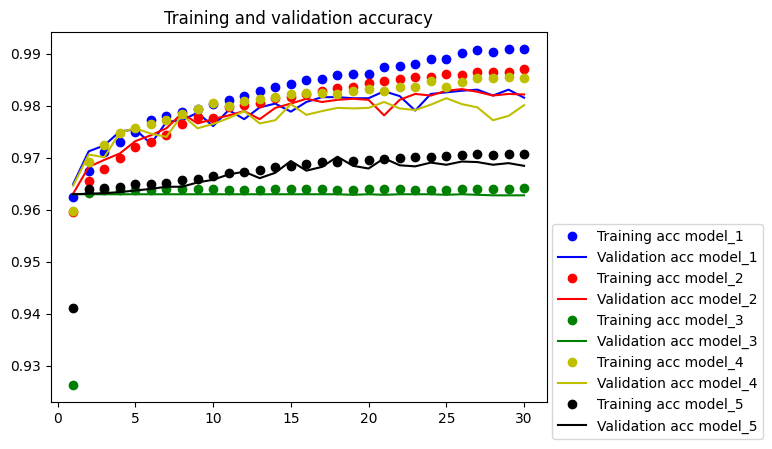

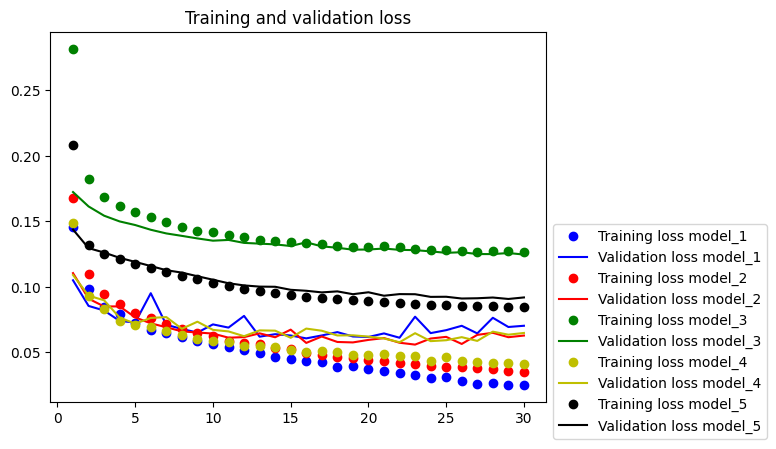

In [91]:
# Plot results
import matplotlib.pyplot as plt

acc_1 = history_1.history['acc']
val_acc_1 = history_1.history['val_acc']
loss_1 = history_1.history['loss']
val_loss_1 = history_1.history['val_loss']

acc_2 = history_2.history['acc']
val_acc_2 = history_2.history['val_acc']
loss_2 = history_2.history['loss']
val_loss_2 = history_2.history['val_loss']

acc_3 = history_3.history['acc']
val_acc_3 = history_3.history['val_acc']
loss_3 = history_3.history['loss']
val_loss_3 = history_3.history['val_loss']

acc_4 = history_4.history['acc']
val_acc_4 = history_4.history['val_acc']
loss_4 = history_4.history['loss']
val_loss_4 = history_4.history['val_loss']

acc_5 = history_5.history['acc']
val_acc_5 = history_5.history['val_acc']
loss_5 = history_5.history['loss']
val_loss_5 = history_5.history['val_loss']

epochs = range(1, len(acc_1) + 1)

plt.plot(epochs, acc_1, 'bo', label='Training acc model_1')
plt.plot(epochs, val_acc_1, 'b', label='Validation acc model_1')
plt.plot(epochs, acc_2, 'ro', label='Training acc model_2')
plt.plot(epochs, val_acc_2, 'r', label='Validation acc model_2')
plt.plot(epochs, acc_3, 'go', label='Training acc model_3')
plt.plot(epochs, val_acc_3, 'g', label='Validation acc model_3')
plt.plot(epochs, acc_4, 'yo', label='Training acc model_4')
plt.plot(epochs, val_acc_4, 'y', label='Validation acc model_4')
plt.plot(epochs, acc_5, 'ko', label='Training acc model_5')
plt.plot(epochs, val_acc_5, 'k', label='Validation acc model_5')
plt.title('Training and validation accuracy')
plt.legend( bbox_to_anchor=(1.45, 0.5), fontsize=10)

plt.figure()

plt.plot(epochs, loss_1, 'bo', label='Training loss model_1')
plt.plot(epochs, val_loss_1, 'b', label='Validation loss model_1')
plt.plot(epochs, loss_2, 'ro', label='Training loss model_2')
plt.plot(epochs, val_loss_2, 'r', label='Validation loss model_2')
plt.plot(epochs, loss_3, 'go', label='Training loss model_3')
plt.plot(epochs, val_loss_3, 'g', label='Validation loss model_3')
plt.plot(epochs, loss_4, 'yo', label='Training loss model_4')
plt.plot(epochs, val_loss_4, 'y', label='Validation loss model_4')
plt.plot(epochs, loss_5, 'ko', label='Training loss model_5')
plt.plot(epochs, val_loss_5, 'k', label='Validation loss model_5')
plt.title('Training and validation loss')
plt.legend( bbox_to_anchor=(1, 0.5), fontsize=10)

plt.show()

In [94]:
models.save_model(model_1, model_1_filename)
models.save_model(model_2, model_2_filename)
models.save_model(model_3, model_3_filename)
models.save_model(model_4, model_4_filename)
models.save_model(model_5, model_5_filename)

/tmp/ipykernel_5354/758715730.py:1: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  models.save_model(model_1, model_1_filename)
/tmp/ipykernel_5354/758715730.py:2: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  models.save_model(model_2, model_2_filename)
/tmp/ipykernel_5354/758715730.py:3: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  models.save_model(model_3, model_3_filename)
/tmp/ipykernel_5354/758715730.py:4: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered 

In [73]:
# See which are 'go'
count = 0
for idx, y in enumerate(y_test):
    if y == 1:
        count += 1
        print(idx)

print(count)

7
48
82
133
145
215
294
325
326
410
450
481
497
515
583
584
604
613
644
649
838
856
902
977
989
1068
1182
1224
1232
1308
1348
1464
1485
1501
1531
1546
1563
1577
1597
1617
1742
1770
1792
1850
1862
1926
1931
1981
2000
2040
2056
2062
2064
2068
2091
2143
2145
2189
2193
2237
2241
2246
2262
2301
2350
2377
2408
2419
2457
2470
2476
2510
2545
2589
2624
2633
2651
2672
2695
2757
2780
2784
2835
2862
2883
2931
2934
2951
2963
2970
3007
3012
3044
3083
3211
3224
3246
3267
3336
3426
3441
3475
3514
3561
3599
3601
3613
3656
3662
3665
3693
3735
3741
3786
3809
3835
3862
3868
3923
3952
3993
3994
4001
4028
4042
4097
4112
4123
4146
4147
4167
4193
4225
4244
4272
4296
4346
4355
4407
4415
4484
4492
4500
4512
4522
4536
4546
4553
4560
4595
4620
4633
4829
4851
4892
4897
4934
4990
5039
5061
5070
5083
5169
5223
5241
5248
5253
5285
5296
5300
5302
5346
5356
5377
5392
5446
5454
5473
5488
5490
5498
5592
5600
5604
5663
5677
5678
5697
5699
5795
5811
5818
5853
5858
5859
5890
5902
5937
5959
5984
5986
5992
6034
6067
6073
6092

In [74]:
# Loading model and run it against test set
model_1 = models.load_model(model_1_filename)
for i in range(0, 100):
    print('Answer:', y_test[i], ' Prediction:', model_1.predict(np.expand_dims(x_test[i], 0)))

2024-05-22 15:33:23.204392: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902


1/1 [==============================] - 1s 823ms/step
Answer: 0.0  Prediction: [[1.8907798e-06]]
1/1 [==============================] - 0s 15ms/step
Answer: 0.0  Prediction: [[3.985172e-10]]
1/1 [==============================] - 0s 13ms/step
Answer: 0.0  Prediction: [[1.5026956e-05]]
1/1 [==============================] - 0s 14ms/step
Answer: 0.0  Prediction: [[2.7249132e-06]]
1/1 [==============================] - 0s 14ms/step
Answer: 0.0  Prediction: [[9.4245305e-09]]
1/1 [==============================] - 0s 14ms/step
Answer: 0.0  Prediction: [[7.3325293e-07]]
1/1 [==============================] - 0s 18ms/step
Answer: 0.0  Prediction: [[0.00010669]]
1/1 [==============================] - 0s 14ms/step
Answer: 1.0  Prediction: [[0.9697887]]
1/1 [==============================] - 0s 13ms/step
Answer: 0.0  Prediction: [[5.7286707e-11]]
1/1 [==============================] - 0s 15ms/step
Answer: 0.0  Prediction: [[2.7031568e-09]]
1/1 [==============================] - 0s 14ms/step
Answe

In [75]:
# Evaluate model with test set
model_1 = models.load_model(model_1_filename)
model_2 = models.load_model(model_2_filename)
model_3 = models.load_model(model_3_filename)
model_4 = models.load_model(model_4_filename)
model_5 = models.load_model(model_5_filename)
model_1.evaluate(x=x_test, y=y_test)
model_2.evaluate(x=x_test, y=y_test)
model_3.evaluate(x=x_test, y=y_test)
model_4.evaluate(x=x_test, y=y_test)
model_5.evaluate(x=x_test, y=y_test)

305/305 [==============================] - 1s 1ms/step - loss: 0.0862 - acc: 0.9696


[0.08620060235261917, 0.9695603251457214]

In [72]:
test_sets_path = '/home/pmedur/strojnoUcenje/env/bin/Tensorflow_speech_recognition/tflite-speech-recognition-master'
test_sets_filename = 'further_test_data.npz'
test_sets = np.load(join(test_sets_path, test_sets_filename))
#x_test = test_sets['x_test.npy']
#y_test = test_sets['y_test.npy']
x_test = test_sets['x_test']
y_test = test_sets['y_test']
print(len(x_test), len(y_test))

4736 4736


In [73]:
wake_word_index = all_targets.index(wake_word)
y_test = np.equal(y_test, wake_word_index).astype('float64')
x_test = x_test.reshape(x_test.shape[0], 
                        x_test.shape[1], 
                        x_test.shape[2], 
                        1)
print(y_test.shape)
print(x_test.shape)

(4736,)
(4736, 16, 16, 1)


In [74]:
from tensorflow.keras.models import load_model
model_1 = load_model(best_model_1_filename, custom_objects={'precision_m': precision_m, 'recall_m': recall_m, 'f1_m': f1_m})
model_2 = load_model(best_model_2_filename, custom_objects={'precision_m': precision_m, 'recall_m': recall_m, 'f1_m': f1_m})
model_3 = load_model(best_model_3_filename, custom_objects={'precision_m': precision_m, 'recall_m': recall_m, 'f1_m': f1_m})
model_4 = load_model(best_model_4_filename, custom_objects={'precision_m': precision_m, 'recall_m': recall_m, 'f1_m': f1_m})
model_5 = load_model(best_model_5_filename, custom_objects={'precision_m': precision_m, 'recall_m': recall_m, 'f1_m': f1_m})
model_6 = load_model(best_model_6_filename, custom_objects={'precision_m': precision_m, 'recall_m': recall_m, 'f1_m': f1_m})
model_7 = load_model(best_model_7_filename, custom_objects={'precision_m': precision_m, 'recall_m': recall_m, 'f1_m': f1_m})
model_8 = load_model(best_model_8_filename, custom_objects={'precision_m': precision_m, 'recall_m': recall_m, 'f1_m': f1_m})
model_9 = load_model(best_model_9_filename, custom_objects={'precision_m': precision_m, 'recall_m': recall_m, 'f1_m': f1_m})
model_10 = load_model(best_model_10_filename, custom_objects={'precision_m': precision_m, 'recall_m': recall_m, 'f1_m': f1_m})

303/303 [==============================] - 0s 1ms/step - loss: 0.0890 - acc: 0.9696


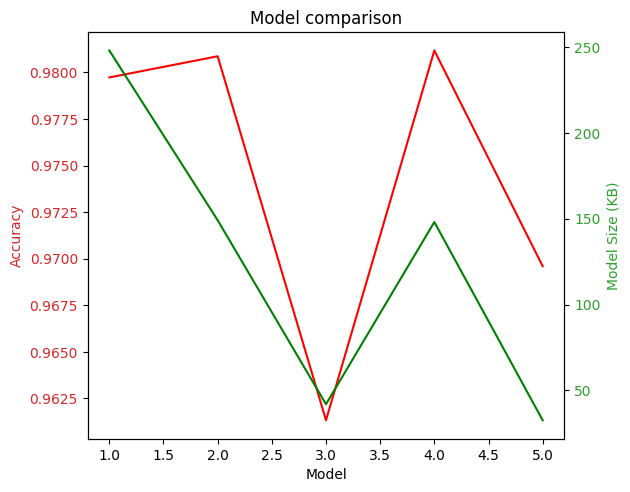

In [101]:
import matplotlib.pyplot as plt
import os

# Assuming model_x and x_test, y_test are already defined and imported
acc_values = []
acc_values.append(model_1.evaluate(x=x_test, y=y_test)[1])
acc_values.append(model_2.evaluate(x=x_test, y=y_test)[1])
acc_values.append(model_3.evaluate(x=x_test, y=y_test)[1])
acc_values.append(model_4.evaluate(x=x_test, y=y_test)[1])
acc_values.append(model_5.evaluate(x=x_test, y=y_test)[1])
acc_values.append(model_6.evaluate(x=x_test, y=y_test)[1])
acc_values.append(model_7.evaluate(x=x_test, y=y_test)[1])
acc_values.append(model_8.evaluate(x=x_test, y=y_test)[1])
acc_values.append(model_9.evaluate(x=x_test, y=y_test)[1])
acc_values.append(model_10.evaluate(x=x_test, y=y_test)[1])

f1_values = []
acc_values.append(model_1.evaluate(x=x_test, y=y_test)[4])
acc_values.append(model_2.evaluate(x=x_test, y=y_test)[4])
acc_values.append(model_3.evaluate(x=x_test, y=y_test)[4])
acc_values.append(model_4.evaluate(x=x_test, y=y_test)[4])
acc_values.append(model_5.evaluate(x=x_test, y=y_test)[4])
acc_values.append(model_6.evaluate(x=x_test, y=y_test)[4])
acc_values.append(model_7.evaluate(x=x_test, y=y_test)[4])
acc_values.append(model_8.evaluate(x=x_test, y=y_test)[4])
acc_values.append(model_9.evaluate(x=x_test, y=y_test)[4])
acc_values.append(model_10.evaluate(x=x_test, y=y_test)[4])

model_size = []
model_size.append(os.path.getsize('wake_word_stop_model_1.h5') / 1024)
model_size.append(os.path.getsize('wake_word_stop_model_2.h5') / 1024)
model_size.append(os.path.getsize('wake_word_stop_model_3.h5') / 1024)
model_size.append(os.path.getsize('wake_word_stop_model_4.h5') / 1024)
model_size.append(os.path.getsize('wake_word_stop_model_5.h5') / 1024)
model_size.append(os.path.getsize('wake_word_stop_model_6.h5') / 1024)
model_size.append(os.path.getsize('wake_word_stop_model_7.h5') / 1024)
model_size.append(os.path.getsize('wake_word_stop_model_8.h5') / 1024)
model_size.append(os.path.getsize('wake_word_stop_model_9.h5') / 1024)
model_size.append(os.path.getsize('wake_word_stop_model_10.h5') / 1024)

# Plot accuracy against model size
plt.figure()
plt.plot(model_size, acc_values, 'bo-')
plt.xlabel('Model Size (KB)')
plt.ylabel('Accuracy')
plt.title('Model Size vs Accuracy')
plt.grid(True)
plt.show()


148/148 [==============================] - 0s 2ms/step - loss: 0.0781 - accuracy: 0.9770 - f1_m: 0.2423


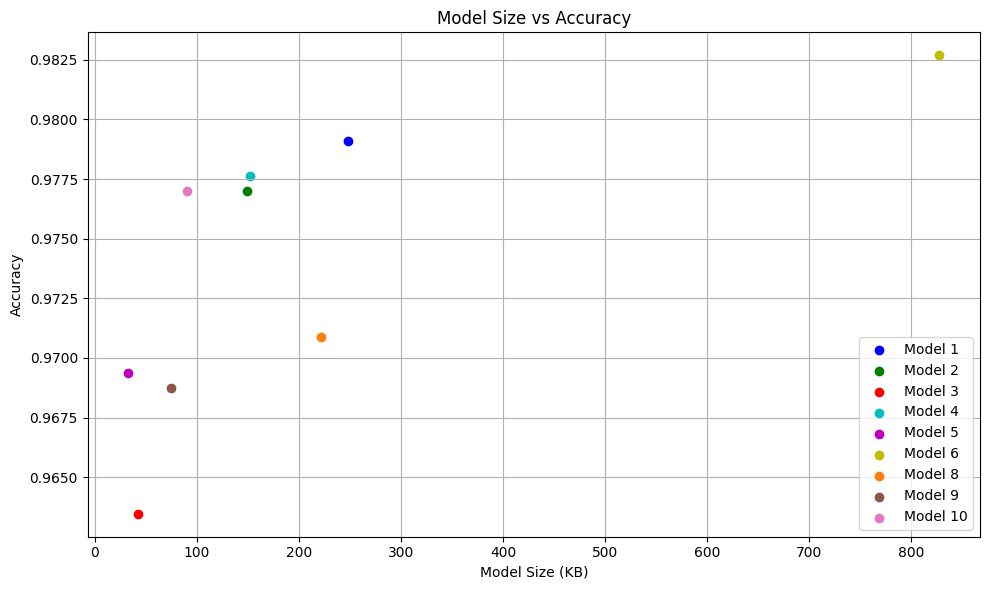

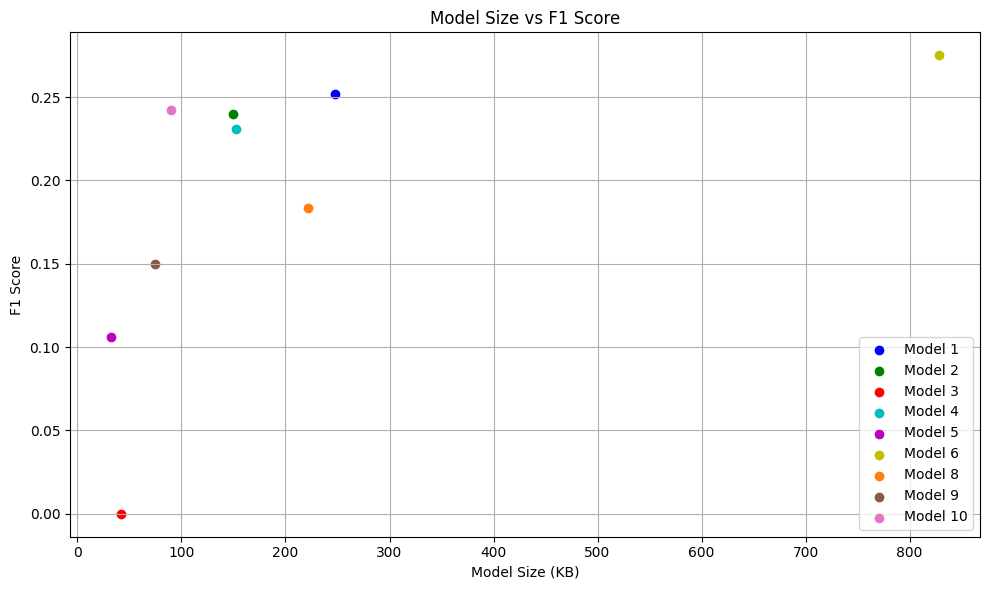

In [54]:
model_files = [
    'models/best_model_1_fold_10.h5',
    'models/best_model_2_fold_10.h5',
    'models/best_model_3_fold_4.h5',
    'models/best_model_4_fold_2.h5',
    'models/best_model_5_fold_4.h5',
    'models/best_model_6_fold_10.h5',
    None,  # Placeholder for missing model
    'models/best_model_8_fold_6.h5',
    'models/best_model_9_fold_3.h5',
    'models/best_model_10_fold_2.h5'
]

# Model sizes
model_h5_size = [
    os.path.getsize(file) / 1024 if file is not None else 0 for file in model_files
]

# Load models with custom metrics
models = [
    load_model(file, custom_objects={'precision_m': precision_m, 'recall_m': recall_m, 'f1_m': f1_m}) if file is not None else None for file in model_files
]
# Evaluate models to get accuracy and F1 score
acc_values = []
f1_values = []

for model in models:
    if model is not None:
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', f1_m])
        results = model.evaluate(x=x_test, y=y_test)
        acc_values.append(results[1])
        f1_values.append(results[2])
    else:
        acc_values.append(None)
        f1_values.append(None)

# Define colors for each model
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'tab:orange', 'tab:brown', 'tab:pink']

# Plot accuracy vs. model size
plt.figure(figsize=(10, 6))
for i in range(len(model_h5_size)):
    if acc_values[i] is not None:
        plt.scatter(model_h5_size[i], acc_values[i], color=colors[i], label=f'Model {i+1}')
plt.xlabel('Model Size (KB)')
plt.ylabel('Accuracy')
plt.title('Model Size vs Accuracy')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Plot F1 score vs. model size
plt.figure(figsize=(10, 6))
for i in range(len(model_h5_size)):
    if f1_values[i] is not None:
        plt.scatter(model_h5_size[i], f1_values[i], color=colors[i], label=f'Model {i+1}')
plt.xlabel('Model Size (KB)')
plt.ylabel('F1 Score')
plt.title('Model Size vs F1 Score')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

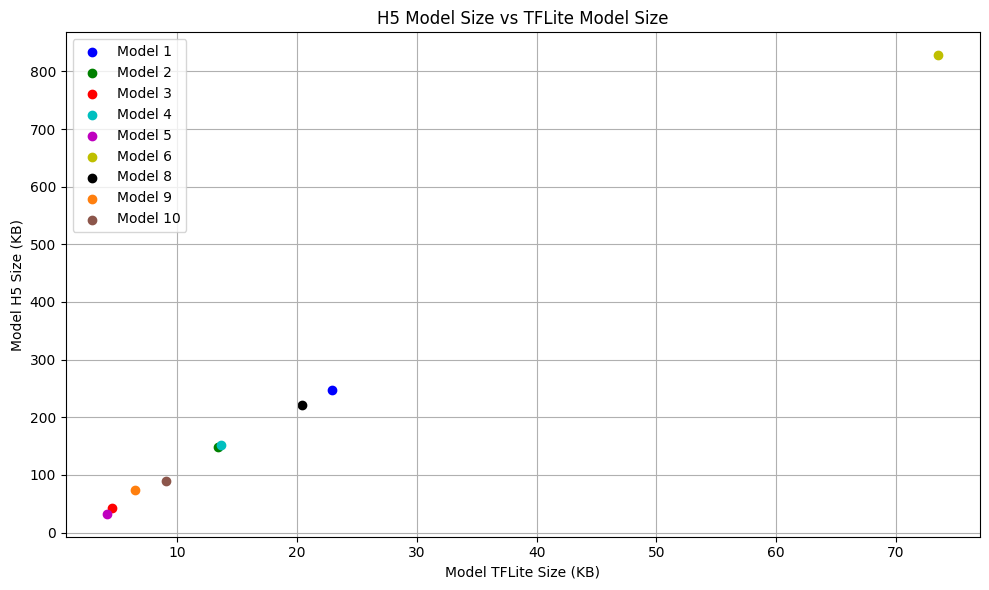

In [23]:
import os
import matplotlib.pyplot as plt

# Model sizes in KB
model_h5_size = [
    os.path.getsize('models/best_model_1_fold_10.h5') / 1024,
    os.path.getsize('models/best_model_2_fold_10.h5') / 1024,
    os.path.getsize('models/best_model_3_fold_4.h5') / 1024,
    os.path.getsize('models/best_model_4_fold_2.h5') / 1024,
    os.path.getsize('models/best_model_5_fold_4.h5') / 1024,
    os.path.getsize('models/best_model_6_fold_10.h5') / 1024,
    0,
    os.path.getsize('models/best_model_8_fold_6.h5') / 1024,
    os.path.getsize('models/best_model_9_fold_3.h5') / 1024,
    os.path.getsize('models/best_model_10_fold_2.h5') / 1024
]

model_tflite_size = [
    os.path.getsize('Converted_models/wake_word_stop_lite_1.tflite') / 1024,
    os.path.getsize('Converted_models/wake_word_stop_lite_2.tflite') / 1024,
    os.path.getsize('Converted_models/wake_word_stop_lite_3.tflite') / 1024,
    os.path.getsize('Converted_models/wake_word_stop_lite_4.tflite') / 1024,
    os.path.getsize('Converted_models/wake_word_stop_lite_5.tflite') / 1024,
    os.path.getsize('Converted_models/wake_word_stop_lite_6.tflite') / 1024,
    0,
    os.path.getsize('Converted_models/wake_word_stop_lite_8.tflite') / 1024,
    os.path.getsize('Converted_models/wake_word_stop_lite_9.tflite') / 1024,
    os.path.getsize('Converted_models/wake_word_stop_lite_10.tflite') / 1024
]

# Filter out pairs where either value is zero
filtered_h5_size = []
filtered_tflite_size = []
model_indices = []

for idx, (h5, tflite) in enumerate(zip(model_h5_size, model_tflite_size)):
    if h5 != 0 and tflite != 0:
        filtered_h5_size.append(h5)
        filtered_tflite_size.append(tflite)
        model_indices.append(idx + 1)

# Define colors for each model
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'tab:orange', 'tab:brown', 'tab:pink']

# Plotting
plt.figure(figsize=(10, 6))

# Scatter plot with different colors for each model
for i in range(len(filtered_h5_size)):
    plt.scatter(filtered_tflite_size[i], filtered_h5_size[i], color=colors[i], label=f'Model {model_indices[i]}')

plt.xlabel('Model TFLite Size (KB)')
plt.ylabel('Model H5 Size (KB)')
plt.title('H5 Model Size vs TFLite Model Size')
plt.grid(True)
plt.legend()
plt.tight_layout()

plt.show()


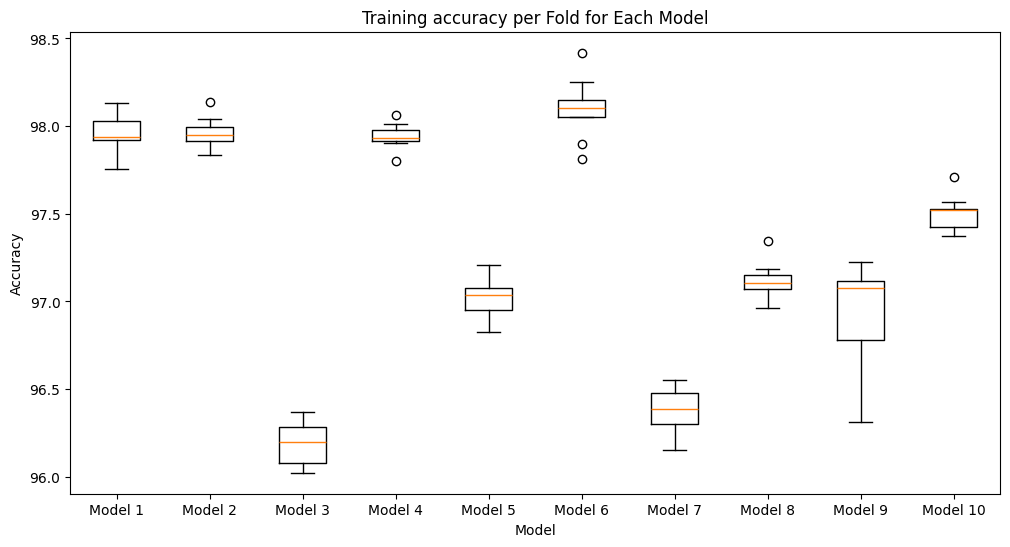

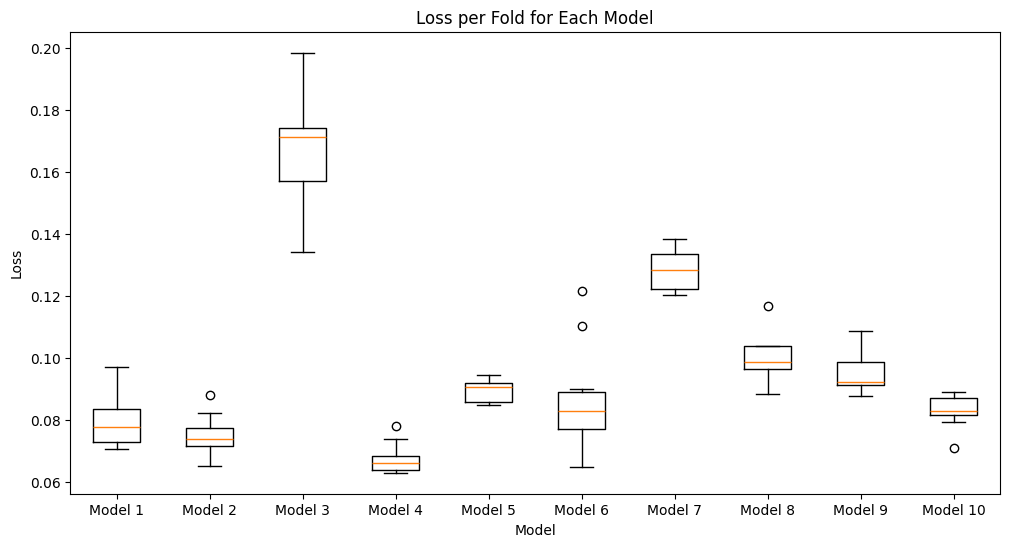

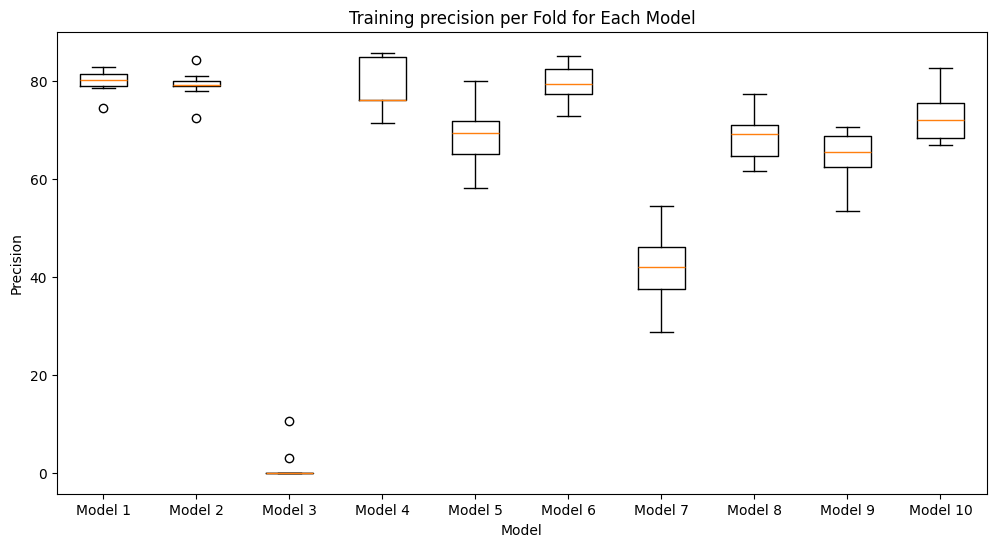

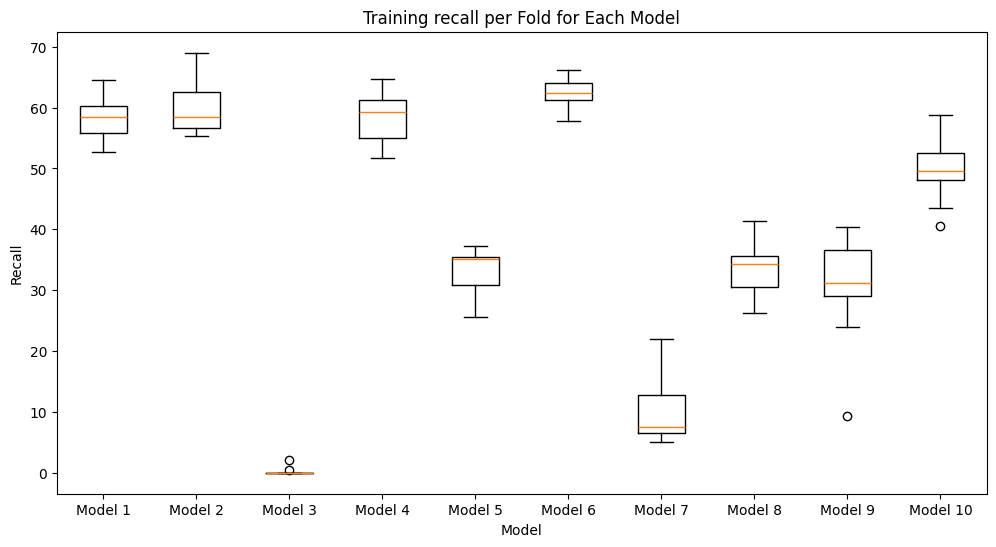

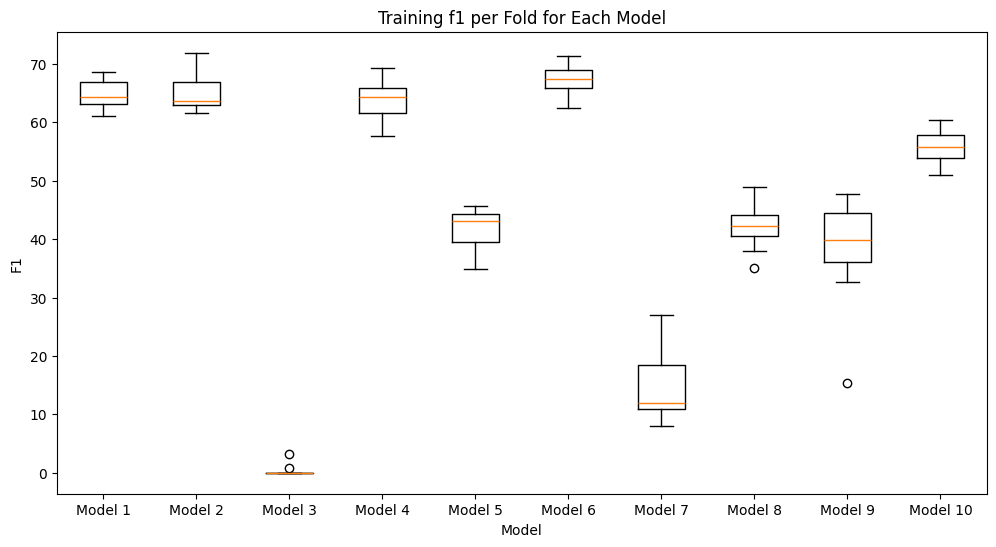

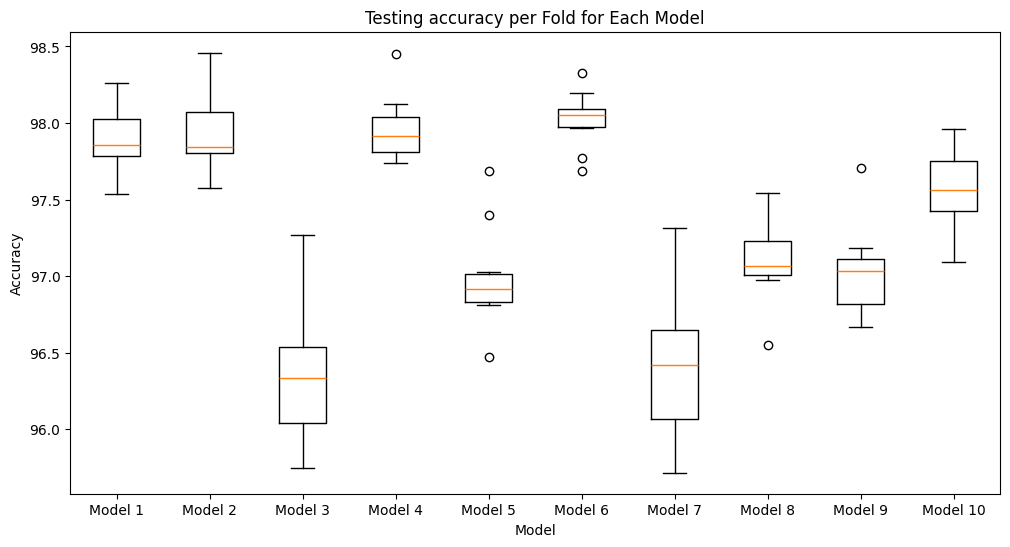

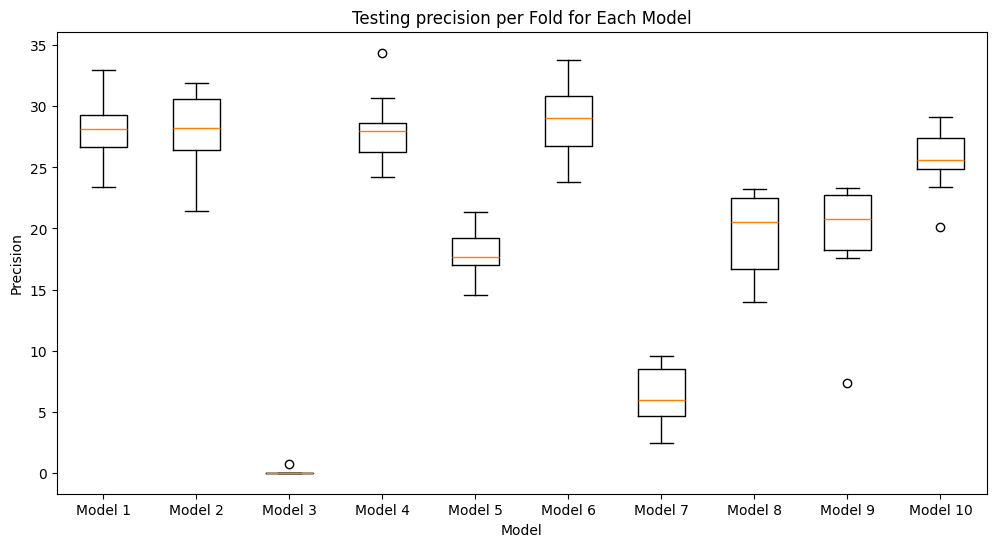

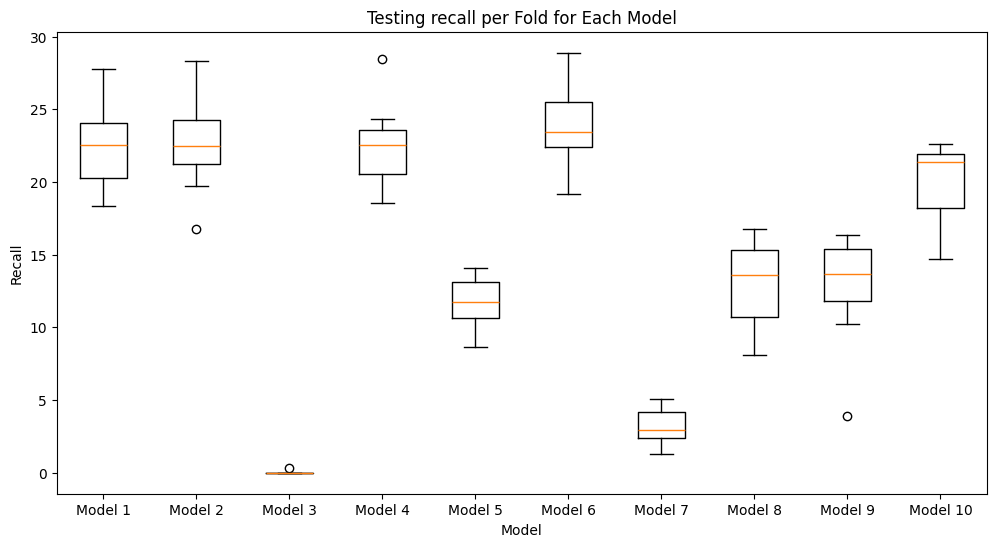

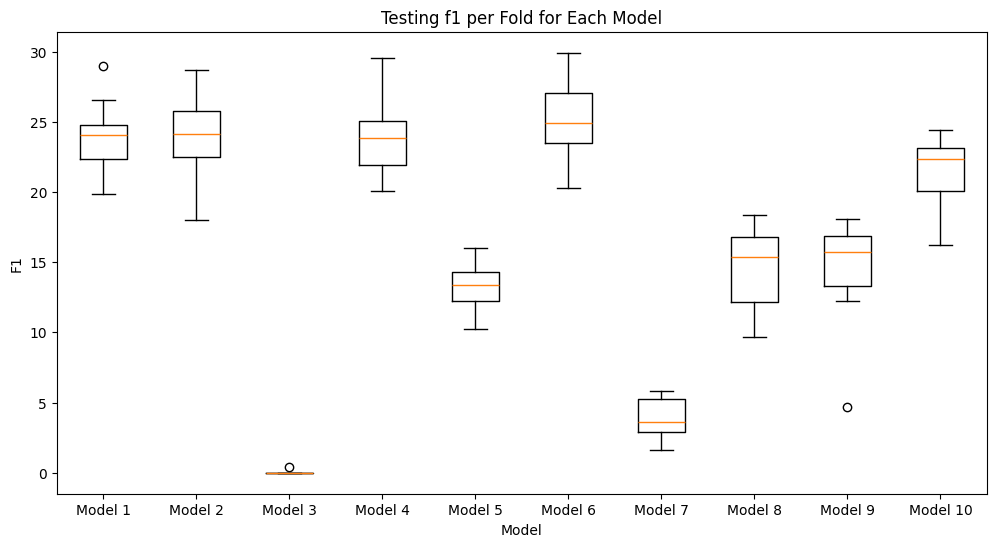

In [27]:
import os
import matplotlib.pyplot as plt
# Put the accuracy data in a list of lists
acc_data = [
    acc_1_per_fold,
    acc_2_per_fold,
    acc_3_per_fold,
    acc_4_per_fold,
    acc_5_per_fold,
    acc_6_per_fold,
    acc_7_per_fold,
    acc_8_per_fold,
    acc_9_per_fold,
    acc_10_per_fold,
]

# Put the loss data in a list of lists
loss_data = [
    loss_1_per_fold,
    loss_2_per_fold,
    loss_3_per_fold,
    loss_4_per_fold,
    loss_5_per_fold,
    loss_6_per_fold,
    loss_7_per_fold,
    loss_8_per_fold,
    loss_9_per_fold,
    loss_10_per_fold,
]

precision_data = [
    precision_1_per_fold,
    precision_2_per_fold,
    precision_3_per_fold,
    precision_4_per_fold,
    precision_5_per_fold,
    precision_6_per_fold,
    precision_7_per_fold,
    precision_8_per_fold,
    precision_9_per_fold,
    precision_10_per_fold,
]

recall_data = [
    recall_1_per_fold,
    recall_2_per_fold,
    recall_3_per_fold,
    recall_4_per_fold,
    recall_5_per_fold,
    recall_6_per_fold,
    recall_7_per_fold,
    recall_8_per_fold,
    recall_9_per_fold,
    recall_10_per_fold,
]

f1_data = [
    f1_1_per_fold,
    f1_2_per_fold,
    f1_3_per_fold,
    f1_4_per_fold,
    f1_5_per_fold,
    f1_6_per_fold,
    f1_7_per_fold,
    f1_8_per_fold,
    f1_9_per_fold,
    f1_10_per_fold,
]

testing_acc_data = [
    testing_acc_1_per_fold,
    testing_acc_2_per_fold,
    testing_acc_3_per_fold,
    testing_acc_4_per_fold,
    testing_acc_5_per_fold,
    testing_acc_6_per_fold,
    testing_acc_7_per_fold,
    testing_acc_8_per_fold,
    testing_acc_9_per_fold,
    testing_acc_10_per_fold,
]

testing_precision_data = [
    testing_precision_1_per_fold,
    testing_precision_2_per_fold,
    testing_precision_3_per_fold,
    testing_precision_4_per_fold,
    testing_precision_5_per_fold,
    testing_precision_6_per_fold,
    testing_precision_7_per_fold,
    testing_precision_8_per_fold,
    testing_precision_9_per_fold,
    testing_precision_10_per_fold,
]

testing_recall_data = [
    testing_recall_1_per_fold,
    testing_recall_2_per_fold,
    testing_recall_3_per_fold,
    testing_recall_4_per_fold,
    testing_recall_5_per_fold,
    testing_recall_6_per_fold,
    testing_recall_7_per_fold,
    testing_recall_8_per_fold,
    testing_recall_9_per_fold,
    testing_recall_10_per_fold,
]

testing_f1_data = [
    testing_f1_1_per_fold,
    testing_f1_2_per_fold,
    testing_f1_3_per_fold,
    testing_f1_4_per_fold,
    testing_f1_5_per_fold,
    testing_f1_6_per_fold,
    testing_f1_7_per_fold,
    testing_f1_8_per_fold,
    testing_f1_9_per_fold,
    testing_f1_10_per_fold,
]

# Create the box plots for accuracy
plt.figure(figsize=(12, 6))
plt.boxplot(acc_data, labels=[f'Model {i+1}' for i in range(10)])
plt.title('Training accuracy per Fold for Each Model')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.show()

# Create the box plots for loss
plt.figure(figsize=(12, 6))
plt.boxplot(loss_data, labels=[f'Model {i+1}' for i in range(10)])
plt.title('Loss per Fold for Each Model')
plt.xlabel('Model')
plt.ylabel('Loss')
plt.show()

plt.figure(figsize=(12, 6))
plt.boxplot(precision_data , labels=[f'Model {i+1}' for i in range(10)])
plt.title('Training precision per Fold for Each Model')
plt.xlabel('Model')
plt.ylabel('Precision')
plt.show()

plt.figure(figsize=(12, 6))
plt.boxplot(recall_data , labels=[f'Model {i+1}' for i in range(10)])
plt.title('Training recall per Fold for Each Model')
plt.xlabel('Model')
plt.ylabel('Recall')
plt.show()

plt.figure(figsize=(12, 6))
plt.boxplot(f1_data , labels=[f'Model {i+1}' for i in range(10)])
plt.title('Training f1 per Fold for Each Model')
plt.xlabel('Model')
plt.ylabel('F1')
plt.show()

plt.figure(figsize=(12, 6))
plt.boxplot(testing_acc_data, labels=[f'Model {i+1}' for i in range(10)])
plt.title('Testing accuracy per Fold for Each Model')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.show()

plt.figure(figsize=(12, 6))
plt.boxplot(testing_precision_data , labels=[f'Model {i+1}' for i in range(10)])
plt.title('Testing precision per Fold for Each Model')
plt.xlabel('Model')
plt.ylabel('Precision')
plt.show()

plt.figure(figsize=(12, 6))
plt.boxplot(testing_recall_data , labels=[f'Model {i+1}' for i in range(10)])
plt.title('Testing recall per Fold for Each Model')
plt.xlabel('Model')
plt.ylabel('Recall')
plt.show()

plt.figure(figsize=(12, 6))
plt.boxplot(testing_f1_data , labels=[f'Model {i+1}' for i in range(10)])
plt.title('Testing f1 per Fold for Each Model')
plt.xlabel('Model')
plt.ylabel('F1')
plt.show()

In [28]:
testing_acc_data = [
    testing_acc_1_per_fold,
    testing_acc_2_per_fold,
    testing_acc_3_per_fold,
    testing_acc_4_per_fold,
    testing_acc_5_per_fold,
    testing_acc_6_per_fold,
    testing_acc_7_per_fold,
    testing_acc_8_per_fold,
    testing_acc_9_per_fold,
    testing_acc_10_per_fold,
]
testing_f1_data = [
    testing_f1_1_per_fold,
    testing_f1_2_per_fold,
    testing_f1_3_per_fold,
    testing_f1_4_per_fold,
    testing_f1_5_per_fold,
    testing_f1_6_per_fold,
    testing_f1_7_per_fold,
    testing_f1_8_per_fold,
    testing_f1_9_per_fold,
    testing_f1_10_per_fold,
]

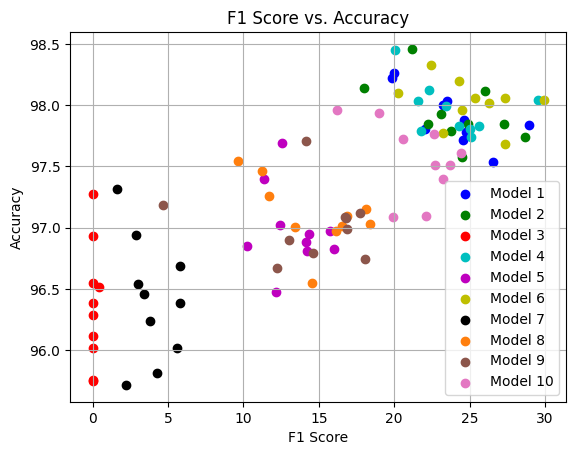

In [29]:
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'tab:orange', 'tab:brown', 'tab:pink'] # define colors for each model

for i in range(len(testing_acc_data)):
    plt.scatter(testing_f1_data[i], testing_acc_data[i], color=colors[i], label=f'Model {i+1}')

plt.xlabel('F1 Score')
plt.ylabel('Accuracy')
plt.title('F1 Score vs. Accuracy')
plt.grid(True)
plt.legend()
plt.show()

In [20]:
best_model_1_filename = 'models/best_model_1_fold_10.h5'
best_model_2_filename = 'models/best_model_2_fold_10.h5'
best_model_3_filename = 'models/best_model_3_fold_4.h5'
best_model_4_filename = 'models/best_model_4_fold_2.h5'
best_model_5_filename = 'models/best_model_5_fold_4.h5'
best_model_6_filename = 'models/best_model_6_fold_10.h5'
best_model_7_filename = 'models/best_model_7_fold_7.h5'
best_model_8_filename = 'models/best_model_8_fold_6.h5'
best_model_9_filename = 'models/best_model_9_fold_3.h5'
best_model_10_filename = 'models/best_model_10_fold_2.h5'

In [40]:
test_sets_path = '/home/pmedur/strojnoUcenje/env/bin/Tensorflow_speech_recognition/tflite-speech-recognition-master'
test_sets_filename = 'further_test_data.npz'
test_sets = np.load(join(test_sets_path, test_sets_filename))
#x_test = test_sets['x_test.npy']
#y_test = test_sets['y_test.npy']
x_test = test_sets['x_test']
y_test = test_sets['y_test']
print(len(x_test), len(y_test))

4736 4736


In [41]:
y_test = np.equal(y_test, wake_word_index).astype('float64')
x_test = x_test.reshape(x_test.shape[0], 
                        x_test.shape[1], 
                        x_test.shape[2], 
                        1)
print(y_test.shape)
print(x_test.shape)

(4736,)
(4736, 16, 16, 1)


In [75]:
model_1 = load_model(best_model_1_filename, custom_objects={'precision_m': precision_m, 'recall_m': recall_m, 'f1_m': f1_m})
model_2 = load_model(best_model_2_filename, custom_objects={'precision_m': precision_m, 'recall_m': recall_m, 'f1_m': f1_m})
model_3 = load_model(best_model_3_filename, custom_objects={'precision_m': precision_m, 'recall_m': recall_m, 'f1_m': f1_m})
model_4 = load_model(best_model_4_filename, custom_objects={'precision_m': precision_m, 'recall_m': recall_m, 'f1_m': f1_m})
model_5 = load_model(best_model_5_filename, custom_objects={'precision_m': precision_m, 'recall_m': recall_m, 'f1_m': f1_m})
model_6 = load_model(best_model_6_filename, custom_objects={'precision_m': precision_m, 'recall_m': recall_m, 'f1_m': f1_m})
model_7 = load_model(best_model_7_filename, custom_objects={'precision_m': precision_m, 'recall_m': recall_m, 'f1_m': f1_m})
model_8 = load_model(best_model_8_filename, custom_objects={'precision_m': precision_m, 'recall_m': recall_m, 'f1_m': f1_m})
model_9 = load_model(best_model_9_filename, custom_objects={'precision_m': precision_m, 'recall_m': recall_m, 'f1_m': f1_m})
model_10 = load_model(best_model_10_filename, custom_objects={'precision_m': precision_m, 'recall_m': recall_m, 'f1_m': f1_m})
model_1.evaluate(x=x_test, y=y_test)
model_2.evaluate(x=x_test, y=y_test)
model_3.evaluate(x=x_test, y=y_test)
model_4.evaluate(x=x_test, y=y_test)
model_5.evaluate(x=x_test, y=y_test)
model_6.evaluate(x=x_test, y=y_test)
model_7.evaluate(x=x_test, y=y_test)
model_8.evaluate(x=x_test, y=y_test)
model_9.evaluate(x=x_test, y=y_test)
model_10.evaluate(x=x_test, y=y_test)

2024-06-15 15:29:07.720104: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902


148/148 [==============================] - 0s 2ms/step - loss: 0.0781 - acc: 0.9770 - precision_m: 0.2804 - recall_m: 0.2291 - f1_m: 0.2423     


[0.07808292657136917,
 0.9769847989082336,
 0.2804053723812103,
 0.2290593981742859,
 0.24225467443466187]

In [19]:
import numpy as np
import tflite_runtime.interpreter as tflite
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from os.path import join

# Load the TFLite model and allocate tensors
interpreter = tflite.Interpreter(model_path='Converted_models/wake_word_stop_lite_1.tflite')
interpreter.allocate_tensors()

# Get input and output tensors
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Load the test data
test_sets_path = '/home/pmedur/strojnoUcenje/env/bin/Tensorflow_speech_recognition/tflite-speech-recognition-master'
test_sets_filename = 'further_test_data.npz'
test_sets = np.load(join(test_sets_path, test_sets_filename))
X_test = test_sets['x_test']
Y_test = test_sets['y_test']

print(len(X_test), len(Y_test))

wake_word_index = all_targets.index(wake_word)

# Reshape X_test if needed
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)
Y_test = np.equal(Y_test, wake_word_index).astype('float32')

# Run inference
predictions = []
for i in range(len(X_test)):
    input_data = np.expand_dims(X_test[i], axis=0).astype(np.float32)
    interpreter.set_tensor(input_details[0]['index'], input_data)
    interpreter.invoke()
    output_data = interpreter.get_tensor(output_details[0]['index'])
    predictions.append(np.round(output_data).flatten()[0])

predictions = np.array(predictions)

# Evaluate the results
accuracy = np.mean(predictions == Y_test)
print(f'Accuracy: {accuracy * 100:.2f}%')

# Calculate precision, recall, and F1 score
precision = precision_score(Y_test, predictions)
recall = recall_score(Y_test, predictions)
f1 = f1_score(Y_test, predictions)

print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')

# Calculate the confusion matrix
tn, fp, fn, tp = confusion_matrix(Y_test, predictions).ravel()
print(f'True Positives: {tp}')
print(f'True Negatives: {tn}')
print(f'False Positives: {fp}')
print(f'False Negatives: {fn}')

# Debugging: Print some predictions and their corresponding true labels
print("Sample Predictions and True Labels:")
for i in range(100):
    print(f"Prediction: {predictions[i]}, True Label: {Y_test[i]}")

# Check the distribution of the predictions
unique, counts = np.unique(predictions, return_counts=True)
print("Prediction Distribution:", dict(zip(unique, counts)))


4736 4736
Accuracy: 97.95%
Precision: 0.77
Recall: 0.63
F1 Score: 0.69
True Positives: 109
True Negatives: 4530
False Positives: 33
False Negatives: 64
Sample Predictions and True Labels:
Prediction: 0.0, True Label: 0.0
Prediction: 0.0, True Label: 0.0
Prediction: 0.0, True Label: 0.0
Prediction: 0.0, True Label: 0.0
Prediction: 0.0, True Label: 0.0
Prediction: 0.0, True Label: 0.0
Prediction: 0.0, True Label: 0.0
Prediction: 0.0, True Label: 0.0
Prediction: 0.0, True Label: 0.0
Prediction: 0.0, True Label: 0.0
Prediction: 0.0, True Label: 0.0
Prediction: 0.0, True Label: 0.0
Prediction: 0.0, True Label: 0.0
Prediction: 0.0, True Label: 0.0
Prediction: 0.0, True Label: 0.0
Prediction: 0.0, True Label: 0.0
Prediction: 0.0, True Label: 0.0
Prediction: 0.0, True Label: 0.0
Prediction: 0.0, True Label: 0.0
Prediction: 0.0, True Label: 0.0
Prediction: 0.0, True Label: 0.0
Prediction: 0.0, True Label: 0.0
Prediction: 0.0, True Label: 0.0
Prediction: 0.0, True Label: 0.0
Prediction: 0.0, Tru

In [63]:
import numpy as np
from os.path import join

# Load the test data
test_sets_path = '/home/pmedur/strojnoUcenje/env/bin/Tensorflow_speech_recognition/tflite-speech-recognition-master'
test_sets_filename = 'further_test_data.npz'
test_sets = np.load(join(test_sets_path, test_sets_filename))
X_test = test_sets['x_test']
Y_test = test_sets['y_test']

wake_word_index = all_targets.index(wake_word)

# Convert Y_test to binary labels based on wake_word_index
Y_test_binary = np.equal(Y_test, wake_word_index).astype('int')

# Count the occurrences of 0s and 1s
label_counts = np.bincount(Y_test_binary)

# Print the counts
print(f'Number of 0s: {label_counts[0]}')
print(f'Number of 1s: {label_counts[1]}')

# Ensure that the Y_test_binary contains only 0s and 1s
assert len(label_counts) == 2, "Y_test_binary should only contain 0s and 1s"

# For completeness, print the total number of samples
print(f'Total samples: {len(Y_test_binary)}')


Number of 0s: 4563
Number of 1s: 173
Total samples: 4736
